# Durchführung eines Diagnose- und Predicitve Maintenance-Projekts (Lea Sagemüller, Enzo Zacharias)

Im Rahmen des Wahlmoduls Diagnose und Predictive Maintenance im fünften Semester des Studiengangs Digitale Technologien wurde als Modulprüfung eine Hausarbeit verfasst, die ein Projekt im Diagnose- und Predictive Maintenance-Bereich beinhaltet. Aus den behandelten Kapiteln der Lehrveranstaltung sollten jeweils Inhalte aufgegriffen werden und auf einen ausgewählten Datensatz angewendet werden. Der Ablauf des Projektes unterteilt sich in die Datenbeschreibung, die Datenvorverarbeitung, die Anomalieerkennung, Predicitve Maintenance sowie die Diagnose und Fehlerursachenerkennung. 

## Auswahl des Datensatzes

Für die Durchführung des Projektes wurde ein passender Datensatz ausgewählt, an welchem die oben genannten Schritte durchgeführt werden können. Der Microsoft Azure Predictive Maintenance-Datensatz auf Kaggle bietet dafür eine umfassende Grundlage. Er umfasst verschiedene Datenquellen, darunter Sensordaten, Fehlerprotokolle, Wartungsinformationen sowie Maschinendaten. Ziel des Datensatzes ist es, Muster und Zusammenhänge zu erkennen, die dabei helfen, Ausfälle frühzeitig vorherzusagen und die Wartungsplanung zu optimieren. 
Die Daten erhalten zeitlich gestempelte Sensormessungen, die den Zustand und Betrieb von Maschinen überwachen, beispielsweise Temperatur- oder Druckwerte. Ergänzend dazu dokumentieren Fehlerprotokolle aufgetretene Störungen, während Wartungslogs Informationen über geplante oder ungeplante Instandhaltungsmaßnahmen bereitstellen. Stammdaten zu den Maschinen, wie Modelltyp oder Alter, sowie Details zu tatsächlichen Ausfällen, einschließlich Ausfalltyp und Zeitstempel, sind ebenfalls Teil des Datensatzes.

## Einlesen der Datensätze und Zusammenführung

### Import der Haupttabelle

In [250]:
import pandas as pd
df = pd.read_csv(r'data/PdM_telemetry.csv')
df.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


Zunächst wird die Haupttabelle "PdM_telemetry.csv" importiert, im Folgenden die vier zusätzlichen Tabellen.

### Zusatz-Tabellen importieren

In [251]:
import pandas as pd
df_errors = pd.read_csv(r'data/PdM_errors.csv')
df_failures = pd.read_csv(r'data/PdM_failures.csv')
df_maint = pd.read_csv(r'data/PdM_maint.csv')
df_machines = pd.read_csv(r'data/PdM_machines.csv')

### Ausgabe der einzelnen Datensätze

Nun werden jeweils die ersten fünf Einträge aus den erstellten Dataframes der einzelnen Datensätze ausgegeben.

In [252]:
# Ausgabe der Errors
df_errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [253]:
# Ausgabe der Failures
df_failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [254]:
# Ausgabe von Maint
df_maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [255]:
# Ausgabe von Machines
df_machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


Hier weiß ich nicht mehr, was genau der Plan war:

Hier könnte man diese Tabelle exemplarisch als Beispiel aufzeigen --> Danach zusammenführen in einem Dataframe in Bezug auf machineID und datetime

In [256]:
import pandas as pd
import os

# Definieren des Dateipfades
directory = r'data'
files = [r'PdM_errors.csv', r'PdM_failures.csv', r'PdM_machines.csv', r'PdM_maint.csv', r'PdM_telemetry.csv']

dfs = {}
for file in files:
    filepath = os.path.join(directory, file)
    df_name = file.split('.')[0]
    dfs[df_name] = pd.read_csv(filepath)

merged_df = dfs['PdM_telemetry']
merged_df = merged_df.merge(dfs['PdM_errors'], on=['datetime', 'machineID'], how='left')
merged_df = merged_df.merge(dfs['PdM_failures'], on=['datetime', 'machineID'], how='left')
merged_df = merged_df.merge(dfs['PdM_maint'], on=['datetime', 'machineID'], how='left')
merged_df = merged_df.merge(dfs['PdM_machines'], on=['machineID'], how='left')

# Speichern des zusammengeführten Dataframes
df = merged_df
merged_df.to_csv(r'data/merged_df.csv', index=False)

Es können nun die einzelnen Dataframes zu einem gemeinsamen Dataframe in Bezug auf die Spalten "datetime" und "machineID" zusammengeführt werden.

## Datenbeschreibung

Im Folgenden wird der im CSV-Format vorliegende zusammengeführte Datensatz importiert und in einen Dataframe eingelesen. Ebenfalls in einen Dataframe eingelesen wird der Datensatz, der die Fehlerinformationen enthält. 

### Anschauen der Daten

In [257]:
df.head()

,datetime,machineID,volt,rotate,pressure,vibration,errorID,failure,comp,model,age
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,NaN,NaN,NaN,model3,18
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,NaN,NaN,NaN,model3,18
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,NaN,NaN,NaN,model3,18
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,NaN,NaN,NaN,model3,18
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,NaN,NaN,NaN,model3,18


Es werden die ersten fünf Einträge des eingelesenen Datensatzes angezeigt, um mehr über die Struktur der Daten zu erfahren.

In [258]:
df.describe()

,machineID,volt,rotate,pressure,vibration,age
count,877209.000000,877209.000000,877209.000000,877209.000000,877209.000000,877209.000000
mean,50.498446,170.780942,446.570735,100.861433,40.386459,11.330280
std,28.866697,15.511268,52.698963,11.052195,5.371894,5.827535
min,1.000000,97.333604,138.432075,51.237106,14.877054,0.000000
25%,25.000000,160.305918,412.265479,93.499116,36.777911,7.000000
50%,50.000000,170.609301,447.537538,100.426820,40.238339,12.000000
75%,75.000000,181.008303,482.157025,107.557338,43.786484,16.000000
max,100.000000,255.124717,695.020984,185.951998,76.791072,20.000000


Die Beschreibung der Daten ist hilfreich, um Informationen wie Minimal- und Maximalwert sowie Mittelwert oder Standardabweichung zu untersuchen und dort ggf. schon erste Auffälligkeiten erkennen zu können.

In [259]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877209 entries, 0 to 877208
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   877209 non-null  object 
 1   machineID  877209 non-null  int64  
 2   volt       877209 non-null  float64
 3   rotate     877209 non-null  float64
 4   pressure   877209 non-null  float64
 5   vibration  877209 non-null  float64
 6   errorID    3924 non-null    object 
 7   failure    1122 non-null    object 
 8   comp       2968 non-null    object 
 9   model      877209 non-null  object 
 10  age        877209 non-null  int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 73.6+ MB


Es werden nun die einzelnen Spalten mit ihren zugehörigen Datentypen angezeigt. Dabei fällt direkt auf, dass die Spalte "datetime" nicht im richtigen Format vorliegt und im weiteren Verlauf angepasst werden muss.

### Plotten aller Messwerte (pro Tag / pro Monat)

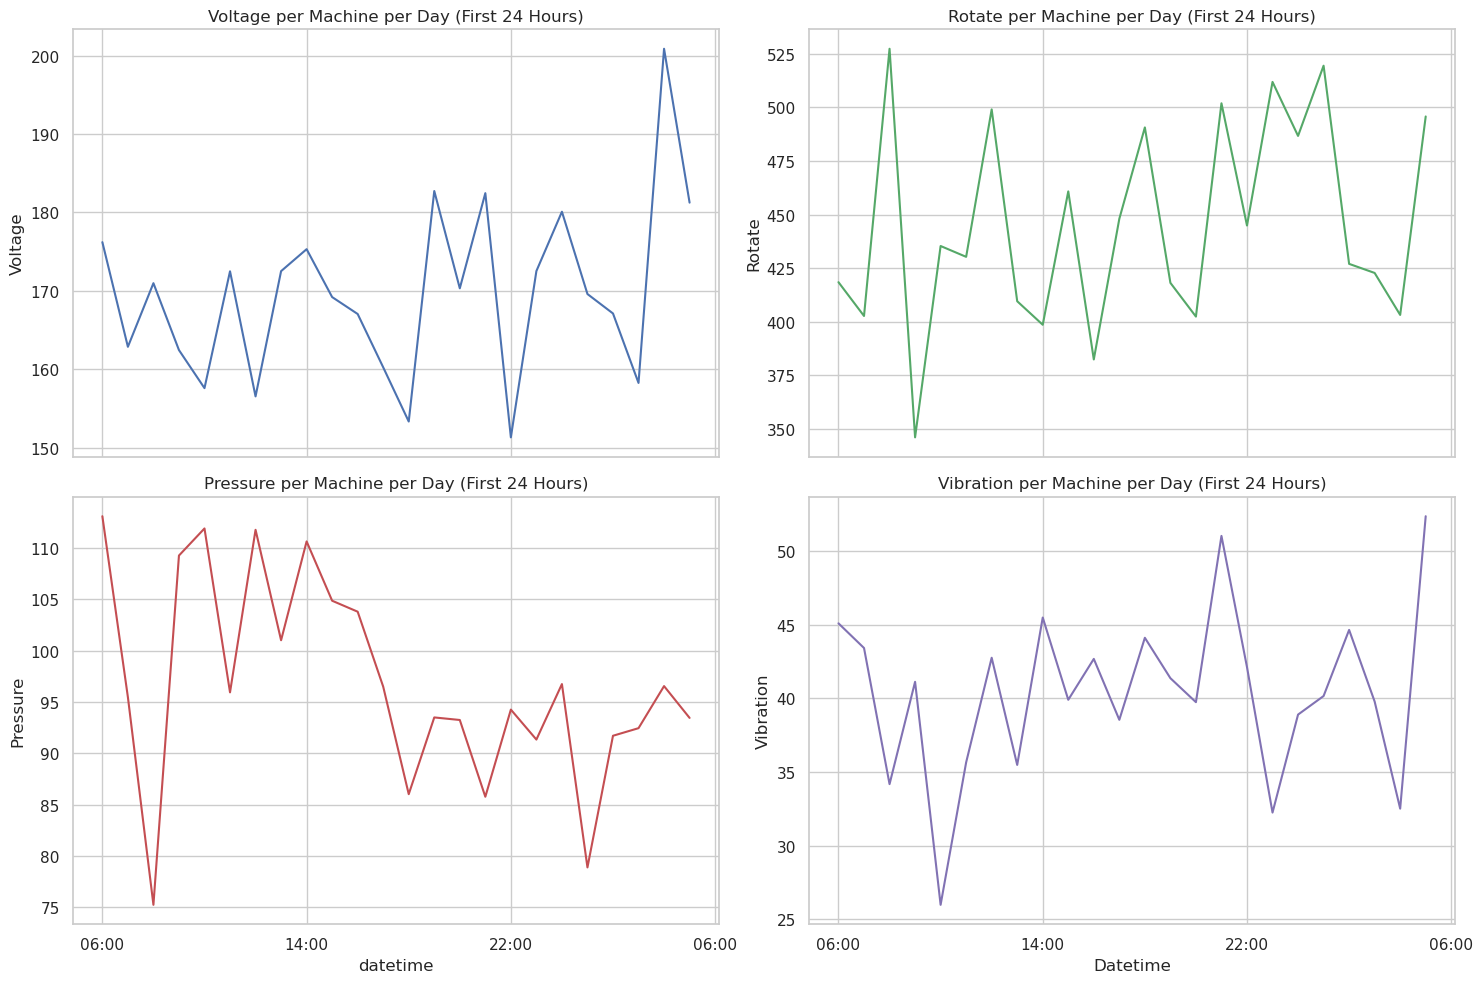

In [260]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

date_format = DateFormatter("%H:%M")

# Filtern der Daten für die ersten 24 Stunden
df_filtered = df[(df['datetime'] >= '2015-01-01 06:00:00') & (df['datetime'] < '2015-01-02 06:00:00') & (df['machineID'] == 1)]
df_filtered['datetime'] = pd.to_datetime(df_filtered['datetime'])

fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

# Plot für Spannung (voltage)
sns.lineplot(x='datetime', y='volt', data=df_filtered, ax=axs[0, 0], color='b')
axs[0, 0].set_title('Voltage per Machine per Day (First 24 Hours)')
axs[0, 0].set_ylabel('Voltage')
axs[0, 0].grid(True)

# Plot für Drehzahl (rotate)
sns.lineplot(x='datetime', y='rotate', data=df_filtered, ax=axs[0, 1], color='g')
axs[0, 1].set_title('Rotate per Machine per Day (First 24 Hours)')
axs[0, 1].set_ylabel('Rotate')
axs[0, 1].grid(True)

# Plot für Druck (pressure)
sns.lineplot(x='datetime', y='pressure', data=df_filtered, ax=axs[1, 0], color='r')
axs[1, 0].set_title('Pressure per Machine per Day (First 24 Hours)')
axs[1, 0].set_ylabel('Pressure')
axs[1, 0].grid(True)

# Plot für Vibration (vibration)
sns.lineplot(x='datetime', y='vibration', data=df_filtered, ax=axs[1, 1], color='m')
axs[1, 1].set_title('Vibration per Machine per Day (First 24 Hours)')
axs[1, 1].set_ylabel('Vibration')
axs[1, 1].set_xlabel('Datetime')
axs[1, 1].grid(True)

# Formatieren der x-Achse, um nur die Stunden anzuzeigen
for ax in axs.flat:
    ax.xaxis.set_major_formatter(date_format)
    # Setzen der xticks auf vier Zeitpunkte
    xticks = pd.date_range(start='2015-01-01 06:00:00', end='2015-01-02 06:00:00', periods=4)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks.strftime('%H:%M'))

plt.tight_layout()
plt.show()


In diesem Code werden für die erste Maschine ("machineID" = 1) die Messdaten für Spannung (Voltage), Drehzahl (Rotate), Druck (Pressure) und Vibration in separaten Diagrammen visualisiert. Die Daten werden auf einen Zeitraum von 24 Stunden (vom 1. Januar 2015, 06:00 Uhr bis zum 2. Januar 2015, 06:00 Uhr) gefiltert. Dabei zeigt die x-Achse nur den Zeitstempel, formatiert als Uhrzeit (Stunden:Minuten), da nur auf 24 Stunden gefiltert wurde. 

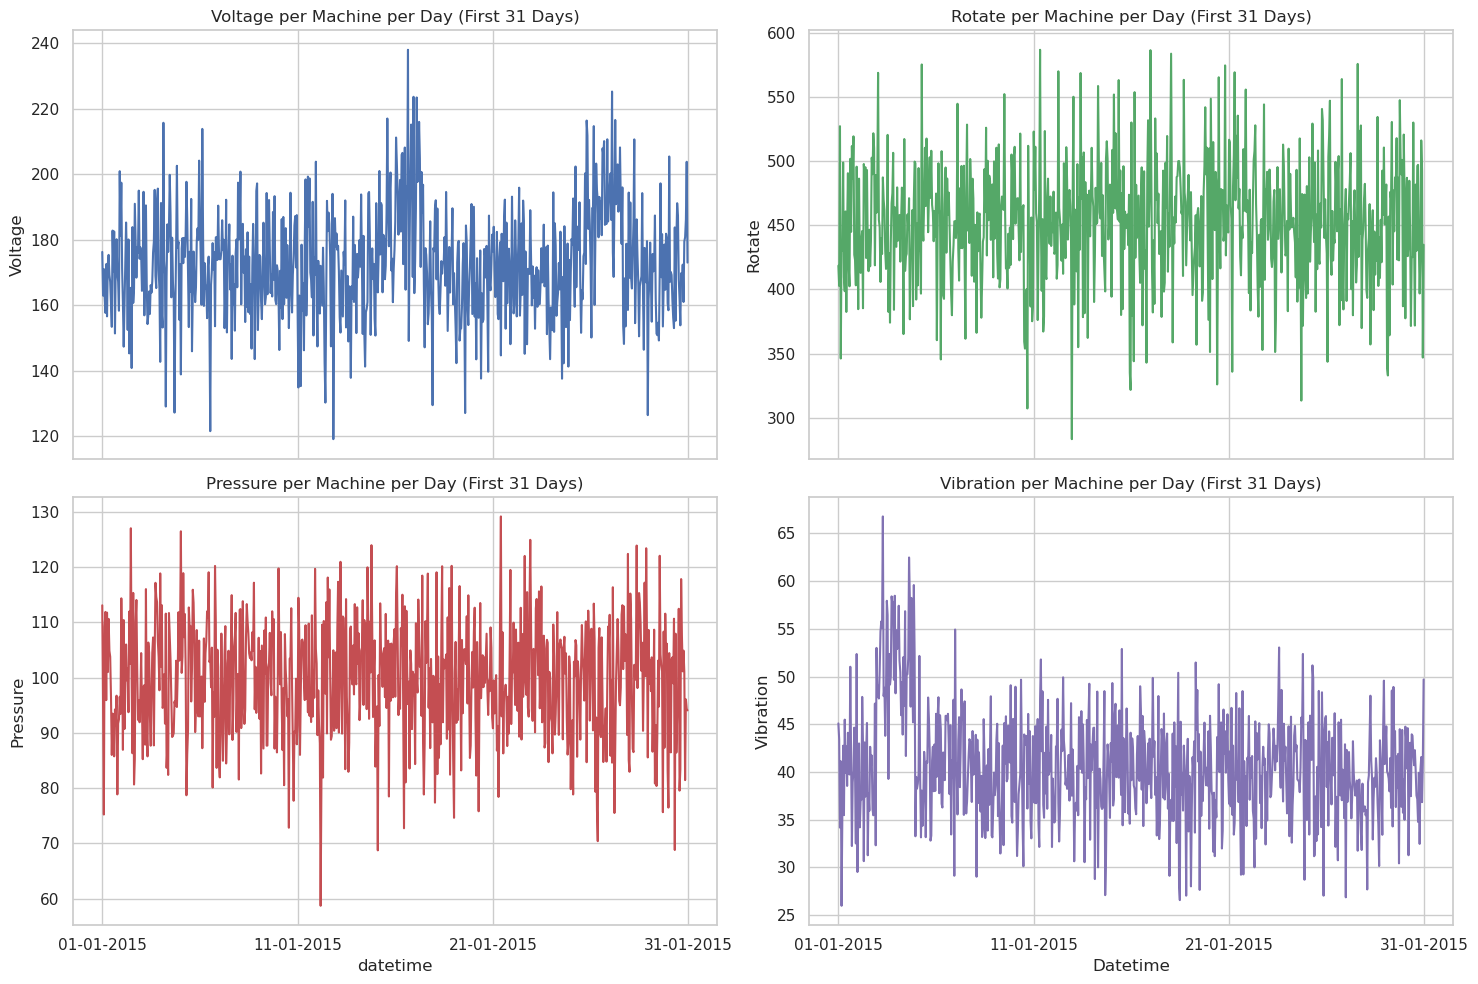

In [261]:
from matplotlib.dates import DateFormatter

date_format = DateFormatter("%d-%m-%Y")

# Filtern der Daten für die ersten 31 Tage
df_filtered = df[(df['datetime'] >= '2015-01-01 06:00:00') & (df['datetime'] < '2015-01-31 23:59:00') & (df['machineID'] == 1)]
df_filtered['datetime'] = pd.to_datetime(df_filtered['datetime'])
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

# Plot für Spannung (voltage)
sns.lineplot(x='datetime', y='volt', data=df_filtered, ax=axs[0, 0], color='b')
axs[0, 0].set_title('Voltage per Machine per Day (First 31 Days)')
axs[0, 0].set_ylabel('Voltage')
axs[0, 0].grid(True)

# Plot für Drehzahl (rotate)
sns.lineplot(x='datetime', y='rotate', data=df_filtered, ax=axs[0, 1], color='g')
axs[0, 1].set_title('Rotate per Machine per Day (First 31 Days)')
axs[0, 1].set_ylabel('Rotate')
axs[0, 1].grid(True)

# Plot für Druck (pressure)
sns.lineplot(x='datetime', y='pressure', data=df_filtered, ax=axs[1, 0], color='r')
axs[1, 0].set_title('Pressure per Machine per Day (First 31 Days)')
axs[1, 0].set_ylabel('Pressure')
axs[1, 0].grid(True)

# Plot für Vibration (vibration)
sns.lineplot(x='datetime', y='vibration', data=df_filtered, ax=axs[1, 1], color='m')
axs[1, 1].set_title('Vibration per Machine per Day (First 31 Days)')
axs[1, 1].set_ylabel('Vibration')
axs[1, 1].set_xlabel('Datetime')
axs[1, 1].grid(True)

# Formatieren der x-Achse, um nur die Tage anzuzeigen
for ax in axs.flat:
    ax.xaxis.set_major_formatter(date_format)
    # Setzen der xticks auf vier Zeitpunkte
    xticks = pd.date_range(start='2015-01-01 06:00:00', end='2015-01-31 23:59:00', periods=4)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks.strftime('%d-%m-%Y'))

plt.tight_layout()
plt.show()

Dieser Code ist fast identisch zum vorherigen mit dem Unterschied, dass nun ein Zeitraum von 31 Tagen betrachtet wird und demnach auch die x-Achse in Tagen statt in Stunden und Minuten angezeit werden soll.

### Anzeigen der größten und kleinsten Ausprägungen pro Attribut

In [262]:
min_timestamp = df['datetime'].min()
max_timestamp = df['datetime'].max()

print(f'Minimum timestamp: {min_timestamp}')
print(f'Maximum timestamp: {max_timestamp}\n')

min_volt = df['volt'].min()
max_volt = df['volt'].max()

print(f'Minimum voltage: {min_volt:.2f}')
print(f'Maximum voltage: {max_volt:.2f}\n')

min_rotate = df['rotate'].min()
max_rotate = df['rotate'].max()

print(f'Minimum rotate: {min_rotate:.2f}')
print(f'Maximum rotate: {max_rotate:.2f}\n')

min_pressure = df['pressure'].min()
max_pressure = df['pressure'].max()

print(f'Minimum pressure: {min_pressure:.2f}')
print(f'Maximum pressure: {max_pressure:.2f}\n')

min_vibration = df['vibration'].min()
max_vibration = df['vibration'].max()

print(f'Minimum vibration: {min_vibration:.2f}')
print(f'Maximum vibration: {max_vibration:.2f}\n')

min_age = df['age'].min()
max_age = df['age'].max()

print(f'Minimum age: {min_age:.2f}')
print(f'Maximum age: {max_age:.2f}')

Minimum timestamp: 2015-01-01 06:00:00
Maximum timestamp: 2016-01-01 06:00:00

Minimum voltage: 97.33
Maximum voltage: 255.12

Minimum rotate: 138.43
Maximum rotate: 695.02

Minimum pressure: 51.24
Maximum pressure: 185.95

Minimum vibration: 14.88
Maximum vibration: 76.79

Minimum age: 0.00
Maximum age: 20.00


Es werden nun die minimalen und maximalen Werte für verschiedene Attribute im Dataframe berechnet und ausgegeben.Zunächst wird der früheste und späteste Zeitstempel der Datensätze ermittelt und angezeigt. Danach werden die minimalen und maximalen Werte der numerischen Variablen volt (Spannung), rotate (Drehzahl), pressure (Druck), vibration (Vibration) sowie age (Alter der Maschine) berechnet. Diese Analyse gibt einen Überblick über die Verteilung und die Spannweite der Daten.

### Untersuchung der Korrelation

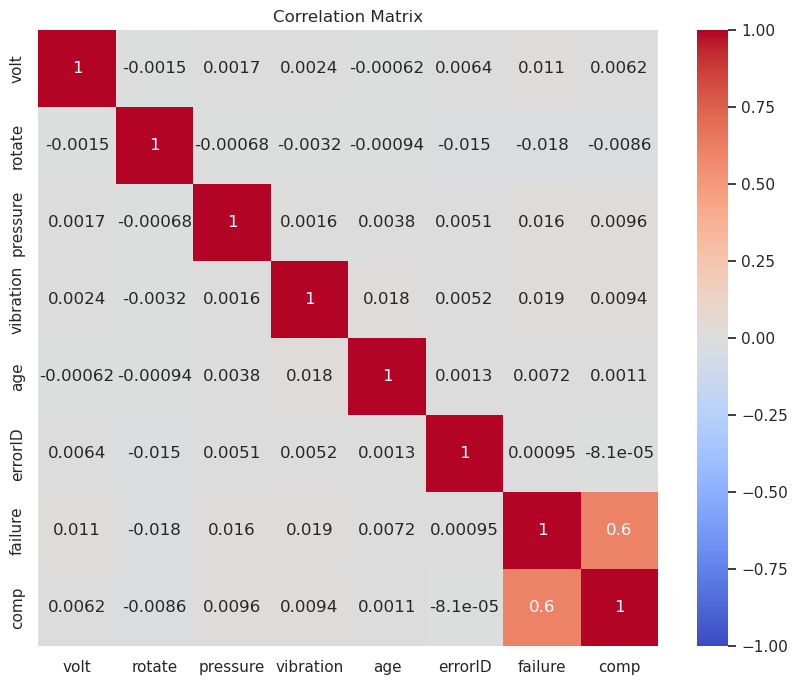

In [263]:
# Formal werden alle Strings von errorID, failure und comp in int-Werte umgewandelt (beachtet werden die NaN-Werte dabei als 0, sonst als 1)
db_bfr = df.copy()
db_bfr['errorID'] = db_bfr['errorID'].apply(lambda x: 0 if pd.isnull(x) else 1)
db_bfr['failure'] = db_bfr['failure'].apply(lambda x: 0 if pd.isnull(x) else 1)
db_bfr['comp'] = db_bfr['comp'].apply(lambda x: 0 if pd.isnull(x) else 1)
correlation = db_bfr[['volt', 'rotate', 'pressure', 'vibration', 'age', 'errorID', 'failure', 'comp']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Zur Untersuchung der Korrelation werden zunächst die Spalten errorID, failure und comp in numerische Werte umgewandelt, wobei NaN-Werte als 0 und alle anderen als 1 interpretiert werden. Anschließend wird eine Korrelationsmatrix berechnet, die die linearen Zusammenhänge zwischen den Variablen volt, rotate, pressure, vibration, age, errorID, failure und comp darstellt. Diese wird mit einer Heatmap visualisiert. Die Darstellung ermöglicht es, potenzielle Zusammenhänge und Einflussfaktoren auf Fehler und Ausfälle zu erkennen. Dabei ist in diesem Fall eine Korrelation zwischen failure und comp erkennbar.

In [ ]:
# Autokorrelation von volt, rotate, pressure und vibration (Korrelation mit sich selbst in Bezug auf die Zeit)

from statsmodels.graphics.tsaplots import plot_acf

fig, axs = plt.subplots(4, 1, figsize=(12, 24))

# Autokorrelation von volt
plot_acf(df['volt'], lags=100, ax=axs[0])
axs[0].set_title('Autocorrelation of Voltage')

# Autokorrelation von rotate
plot_acf(df['rotate'], lags=100, ax=axs[1])
axs[1].set_title('Autocorrelation of Rotate')

# Autokorrelation von pressure
plot_acf(df['pressure'], lags=100, ax=axs[2])
axs[2].set_title('Autocorrelation of Pressure')

# Autokorrelation von vibration
plot_acf(df['vibration'], lags=100, ax=axs[3])
axs[3].set_title('Autocorrelation of Vibration')

plt.tight_layout()
plt.show()


"\nfrom statsmodels.graphics.tsaplots import plot_acf\n\nfig, axs = plt.subplots(4, 1, figsize=(12, 24))\n\n# Autokorrelation von volt\nplot_acf(df['volt'], lags=100, ax=axs[0])\naxs[0].set_title('Autocorrelation of Voltage')\n\n# Autokorrelation von rotate\nplot_acf(df['rotate'], lags=100, ax=axs[1])\naxs[1].set_title('Autocorrelation of Rotate')\n\n# Autokorrelation von pressure\nplot_acf(df['pressure'], lags=100, ax=axs[2])\naxs[2].set_title('Autocorrelation of Pressure')\n\n# Autokorrelation von vibration\nplot_acf(df['vibration'], lags=100, ax=axs[3])\naxs[3].set_title('Autocorrelation of Vibration')\n\nplt.tight_layout()\nplt.show()\n"

Anschließend wird die Autokorrelation für die Variablen volt (Spannung), rotate (Drehzahl), pressure (Druck) und vibration (Vibration) berechnet und in separaten Plots dargestellt. Autokorrelation beschreibt, wie stark eine Zeitreihe mit sich selbst in unterschiedlichen Zeitabständen (Lags) korreliert.

Jeder Plot zeigt die Autokorrelation für bis zu 100 Lags, also Zeitpunkte, die jeweils um eine bestimmte Anzahl von Intervallen voneinander entfernt sind. Ein Wert nahe 1 deutet auf eine starke positive Korrelation hin, ein Wert nahe -1 auf eine starke negative Korrelation. Werte nahe 0 zeigen keine Korrelation. Die Plots ermöglichen es, Muster oder saisonale Abhängigkeiten in den Zeitreihen zu identifizieren.

In allen vier Fällen ist eine schwache Korrelation von höchstens 0,2 zu erkennen.







### Ausfälle pro Maschine

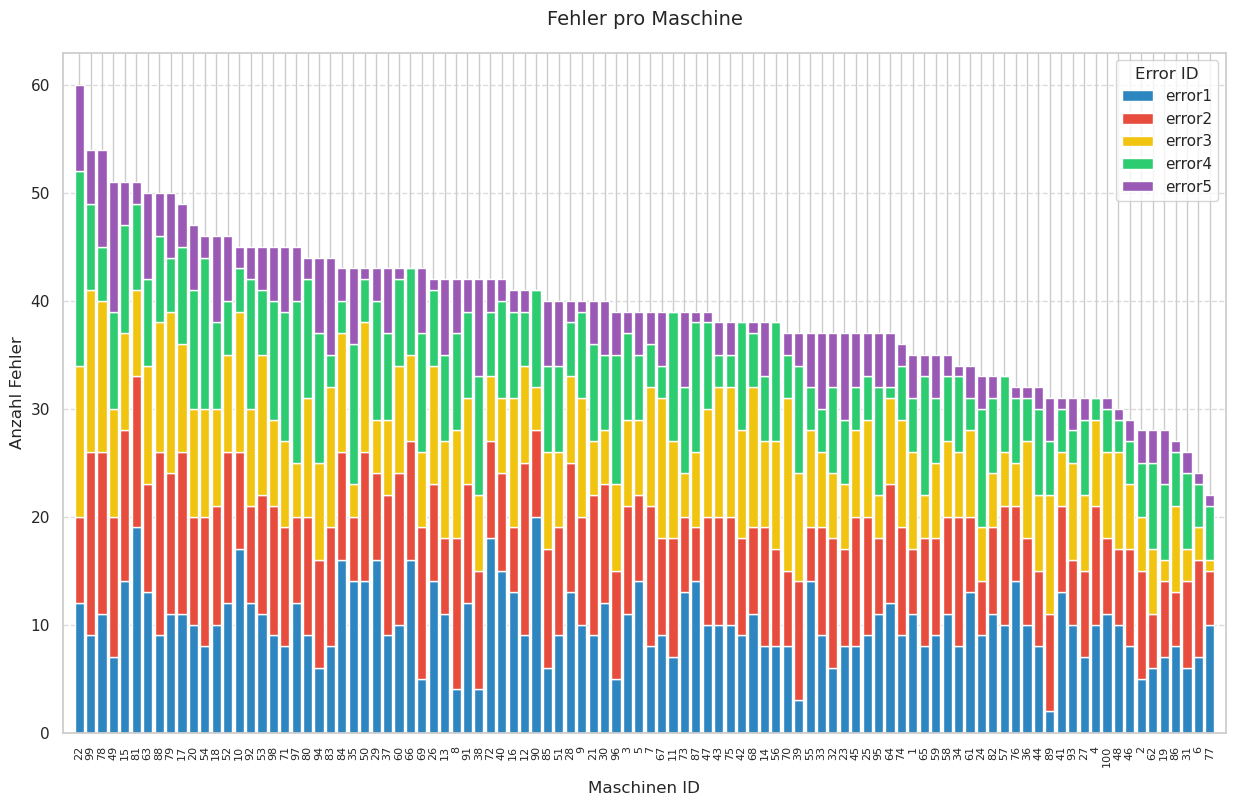

In [265]:
import numpy as np

# Anzahl Ausfälle pro Maschine und errorID als DataFrame erstellen und sortieren
failure_count = df.groupby(['machineID', 'errorID']).size().unstack(fill_value=0)
failure_count_sorted = failure_count.sum(axis=1).sort_values(ascending=False)

# Figur mit angepasster Größe erstellen
plt.figure(figsize=(15, 10))  

# Balkendiagramm erstellen
bottom = np.zeros(len(failure_count_sorted))
colors = ['#2E86C1', '#E74C3C', '#F1C40F', '#2ECC71', '#9B59B6']  

for i, errorID in enumerate(failure_count.columns):
    values = failure_count.loc[failure_count_sorted.index, errorID]
    plt.bar(range(len(failure_count_sorted)), values, bottom=bottom, color=colors[i % len(colors)], label=errorID)
    bottom += values

# X-Achsen-Labels mit den entsprechenden Maschinen-IDs
plt.xticks(range(len(failure_count_sorted)), failure_count_sorted.index, 
           rotation=90,  
           ha='center',  
           fontsize=8)   

plt.title('Fehler pro Maschine', fontsize=14, pad=20)
plt.xlabel('Maschinen ID', fontsize=12, labelpad=10)  
plt.ylabel('Anzahl Fehler', fontsize=12)

# Gitter hinzufügen
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ränder anpassen
plt.margins(x=0.01)

plt.subplots_adjust(bottom=0.2)  

# Legende hinzufügen
plt.legend(title='Error ID')

plt.show()

Um die Ausfälle pro Maschine untersuchen zu können, wird ein gestapeltes Balkendiagramm erstellt, das die Anzahl der Fehler pro Maschine und Fehler-ID darstellt. Zunächst werden die Fehlerdaten nach machineID und errorID gruppiert und die Anzahl der Fehler berechnet, wobei fehlende Werte mit 0 aufgefüllt werden. Anschließend werden die Maschinen nach der Gesamtanzahl ihrer Fehler sortiert. Im Diagramm repräsentiert jeder Balken die Gesamtanzahl der Fehler pro Maschine. Das Diagramm ermöglicht es, die fehleranfälligsten Maschinen sowie die Verteilung der Fehlerarten zu erkennen.

### Anzahl an Fehlerklassen

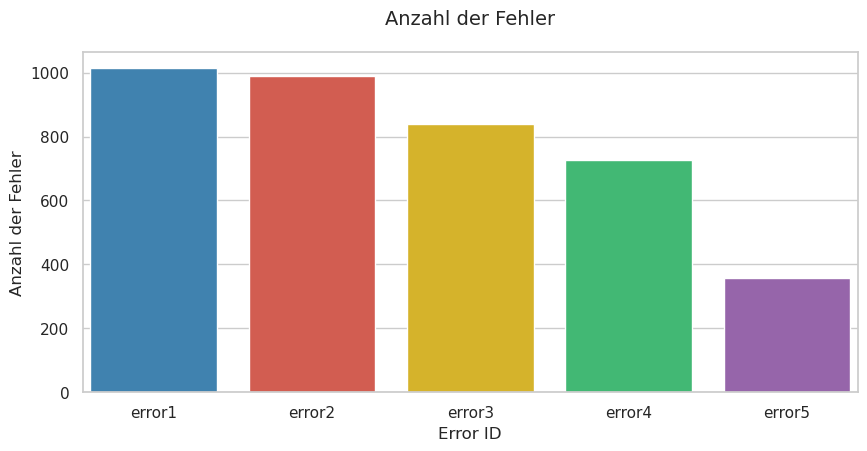

In [266]:
plt.figure(figsize=(10, 5))

# Balkendiagramm erstellen mit x = Error-Klasse und y = Anzahl der Fehler
sns.countplot(x='errorID', data=df, order=df['errorID'].value_counts().index, palette=colors)

plt.title('Anzahl der Fehler', fontsize=14, pad=20)
plt.ylabel('Anzahl der Fehler', fontsize=12)
plt.xlabel('Error ID', fontsize=12)

plt.margins(x=0.01)
plt.subplots_adjust(bottom=0.2)
plt.show()


Mittels eines Balkendiagramms wird die Verteilung der Fehlerarten visualisiert. Dabei wird auf der x-Achse die errorID (Fehlerklasse) und auf der y-Achse die Anzahl der Fehler dargestellt. Die Fehlerarten werden nach ihrer Häufigkeit sortiert. 

### Anzahl der Ausfälle

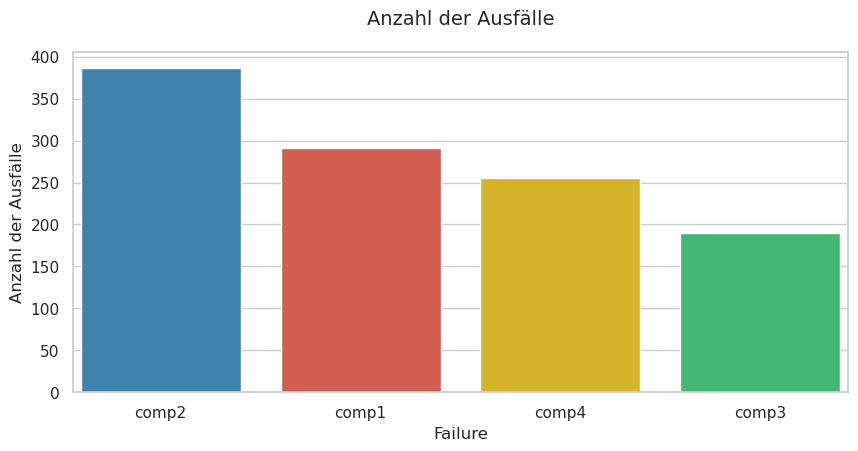

In [267]:
plt.figure(figsize=(10, 5))

# Balkendiagramm erstellen mit x = Error-Klasse und y = Anzahl der Fehler
sns.countplot(x='failure', data=df, order=df['failure'].value_counts().index, palette=colors)

plt.title('Anzahl der Ausfälle', fontsize=14, pad=20)
plt.ylabel('Anzahl der Ausfälle', fontsize=12)
plt.xlabel('Failure', fontsize=12)

plt.margins(x=0.01)
plt.subplots_adjust(bottom=0.2)
plt.show()


Ebenso wie bei zuvor dargestellten Anzahl der Fehler können auch die Anzahl der Ausfälle visualisiert werden. Auch hier lässt sich im erstellten Diagramm erkennen, welche Art der Ausfälle wie häufig vorkommt.

### Verteilung des Alters der Maschinen

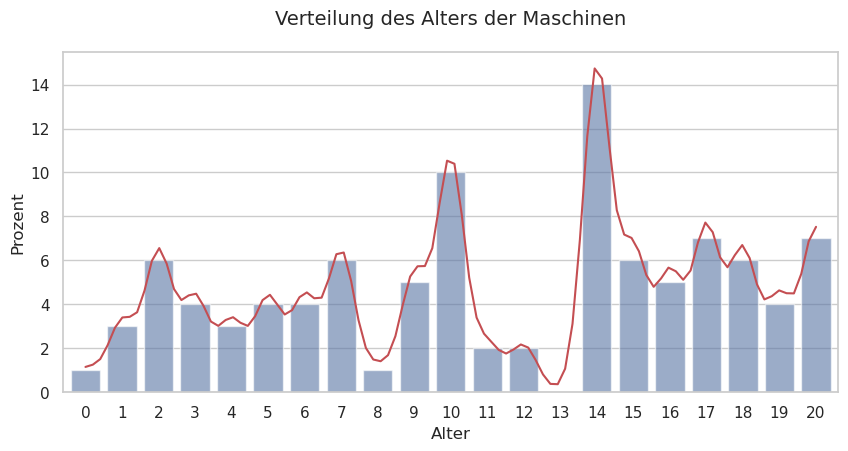

In [268]:
from scipy.stats import gaussian_kde
import numpy as np

# Verteilung des Alters der Maschinen in Prozent
age_distribution = df['age'].value_counts(normalize=True) * 100

# Alter 13 mit 0% hinzufügen
age_distribution = age_distribution.reindex(range(21), fill_value=0)

plt.figure(figsize=(10, 5))

# Balkendiagramm erstellen mit x = Alter und y = Prozent
sns.barplot(x=age_distribution.index, y=age_distribution.values, color='b', alpha=0.6)

# Density Kurve hinzufügen
age_values = df['age'].values
kde = gaussian_kde(age_values)
age_range = np.linspace(age_values.min(), age_values.max(), 100)
age_density = kde(age_range) * 100  # Skalieren auf Prozent

plt.plot(age_range, age_density, color='r')

plt.title('Verteilung des Alters der Maschinen', fontsize=14, pad=20)
plt.ylabel('Prozent', fontsize=12)
plt.xlabel('Alter', fontsize=12)

plt.margins(x=0.01)
plt.subplots_adjust(bottom=0.2)
plt.show()

Anhand des erstellten Säulendiagramms lässt sich die Verteilung des Alters der untersuchten Maschinen darstellen. Dabei wird auf der x-Achse das mögliche Alter abgebildet und auf der y-Achse die Verteilung in Prozent. Die meisten Maschinen sind dabei zehn oder 14 Jahre alt.

### Linearer Zusammenhang (Regression) mit der Anzahl an Ausfällen und dem Alter der Maschine

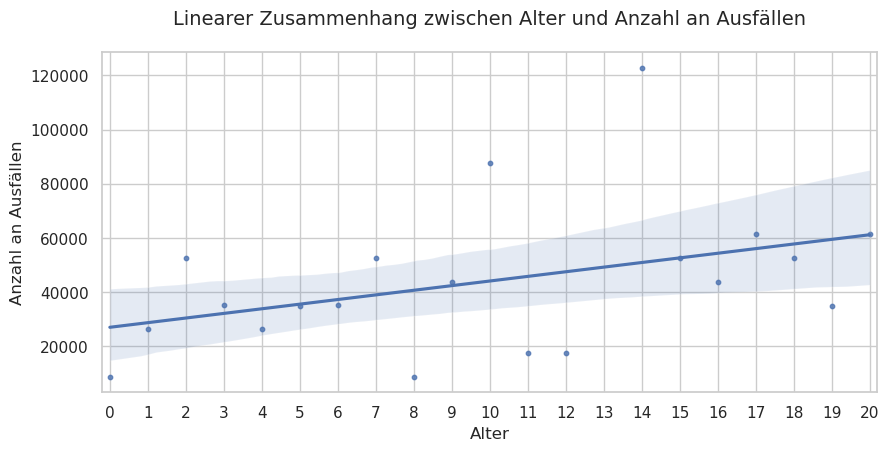

Die Funktion der Geraden lautet: y = 1707.3372559332063x + 27043.178029057915


In [269]:
from sklearn.linear_model import LinearRegression

# Zunächst Summierung der Anzahl an Ausfälle pro Alter
age_error_count = df.groupby('age').size()

# Erstellung einer linearen Darstellung mit Trend (x-Achse = Alter und y = Anzahl an Ausfälle)
plt.figure(figsize=(10, 5))

sns.regplot(x=age_error_count.index, y=age_error_count.values, color='b', scatter_kws={'s': 10})

plt.title('Linearer Zusammenhang zwischen Alter und Anzahl an Ausfällen', fontsize=14, pad=20)
plt.ylabel('Anzahl an Ausfällen', fontsize=12)
plt.xlabel('Alter', fontsize=12)

# Setzen der x-Achse, um jedes Jahr als Strich darzustellen
plt.xticks(ticks=range(age_error_count.index.min(), age_error_count.index.max() + 1))

plt.margins(x=0.01)
plt.subplots_adjust(bottom=0.2)
plt.show()

# Berechnen der Regressionsgeraden
X = age_error_count.index.values.reshape(-1, 1)
y = age_error_count.values

# Erstellung des Modell und Training
model = LinearRegression()
model.fit(X, y)

# Ausgabe der Funktion der Geraden
m = model.coef_[0]
b = model.intercept_
print(f"Die Funktion der Geraden lautet: y = {m}x + {b}")

Im Bereich der Datenbeschreibung wird abschließend noch der Zusammenhang zwischen dem Alter der Maschinen und der Anzahl an Ausfällen visualisiert. Zuerst wird die Anzahl der Ausfälle für jedes Alter summiert. Anschließend wird ein Streudiagramm mit einer linearen Regressionsgeraden erstellt, um den Trend zwischen Alter und Ausfällen darzustellen. Die x-Achse zeigt das Alter der Maschinen und die y-Achse die Anzahl der Ausfälle. Ein lineares Regressionsmodell wird trainiert, um die beste Geradengleichung zu berechnen, die den Zusammenhang beschreibt. Die Koeffizienten der Regressionsgeraden werden schließlich ausgegeben.

## Datenvorberarbeitung


### Umwandlung einzelner Spalten in integer-Werte

In [270]:
# errorID, failure und comp sind nicht numerisch und müssen umgewandelt werden
# Wenn NaN, dann wird 0 eingesetzt, sonst wenn errorID = error1 dann 1, errorID = error2 dann 2, errorID = error3 dann 3,....

df['errorID'] = df['errorID'].fillna(0)
df['errorID'] = df['errorID'].replace('error1', 1)
df['errorID'] = df['errorID'].replace('error2', 2)
df['errorID'] = df['errorID'].replace('error3', 3)
df['errorID'] = df['errorID'].replace('error4', 4)
df['errorID'] = df['errorID'].replace('error5', 5)

df['failure'] = df['failure'].fillna(0)
df['failure'] = df['failure'].replace('comp1', 1)
df['failure'] = df['failure'].replace('comp2', 2)
df['failure'] = df['failure'].replace('comp3', 3)
df['failure'] = df['failure'].replace('comp4', 4)

df['comp'] = df['comp'].fillna(0)
df['comp'] = df['comp'].replace('comp1', 1)
df['comp'] = df['comp'].replace('comp2', 2)
df['comp'] = df['comp'].replace('comp3', 3)
df['comp'] = df['comp'].replace('comp4', 4)

df['model'] = df['model'].fillna(0)
df['model'] = df['model'].replace('model1', 1)
df['model'] = df['model'].replace('model2', 2)
df['model'] = df['model'].replace('model3', 3)
df['model'] = df['model'].replace('model4', 4)

Im ersten Schritt der Datenvorverarbeitung werden die Spalten errorID, failure, comp und model umgewandelt, damit sie nur noch numerische Werte enthalten. Zuerst werden alle NaN-Werte in diesen Spalten durch 0 ersetzt. Danach werden die einzelnen Kategorien, wie beispielweise error1, error2, comp1 oder comp2 durch numerische Werte ersetzt: error1 wird zu 1, error2 zu 2 etc. Dies wird für alle genannten Spalten durchgeführt. Dadurch liegen alle Werte in diesen Spalten als numerische Werte vor und können so für die weitere Analyse verwendet werden.

### Missing Value Treatment

In [271]:
# Testen auf fehlende Werte
print(df.isnull().sum())

datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
errorID      0
failure      0
comp         0
model        0
age          0
dtype: int64


Beim Missing Value Treatment wird der Dataframe auf fehlende Werte überprüft. Dies ist hier jedoch nicht der Fall, da für alle Variablen der Wert 0 ausgegeben wird. Dadurch ist ebenfalls keine Interpolation oder ähnliches notwendig.

### Ausreißer-Analyse (statistisch und dichtebasiert)

#### Data Cleaning (Ausreißer identifizieren und ggf. entfernen)

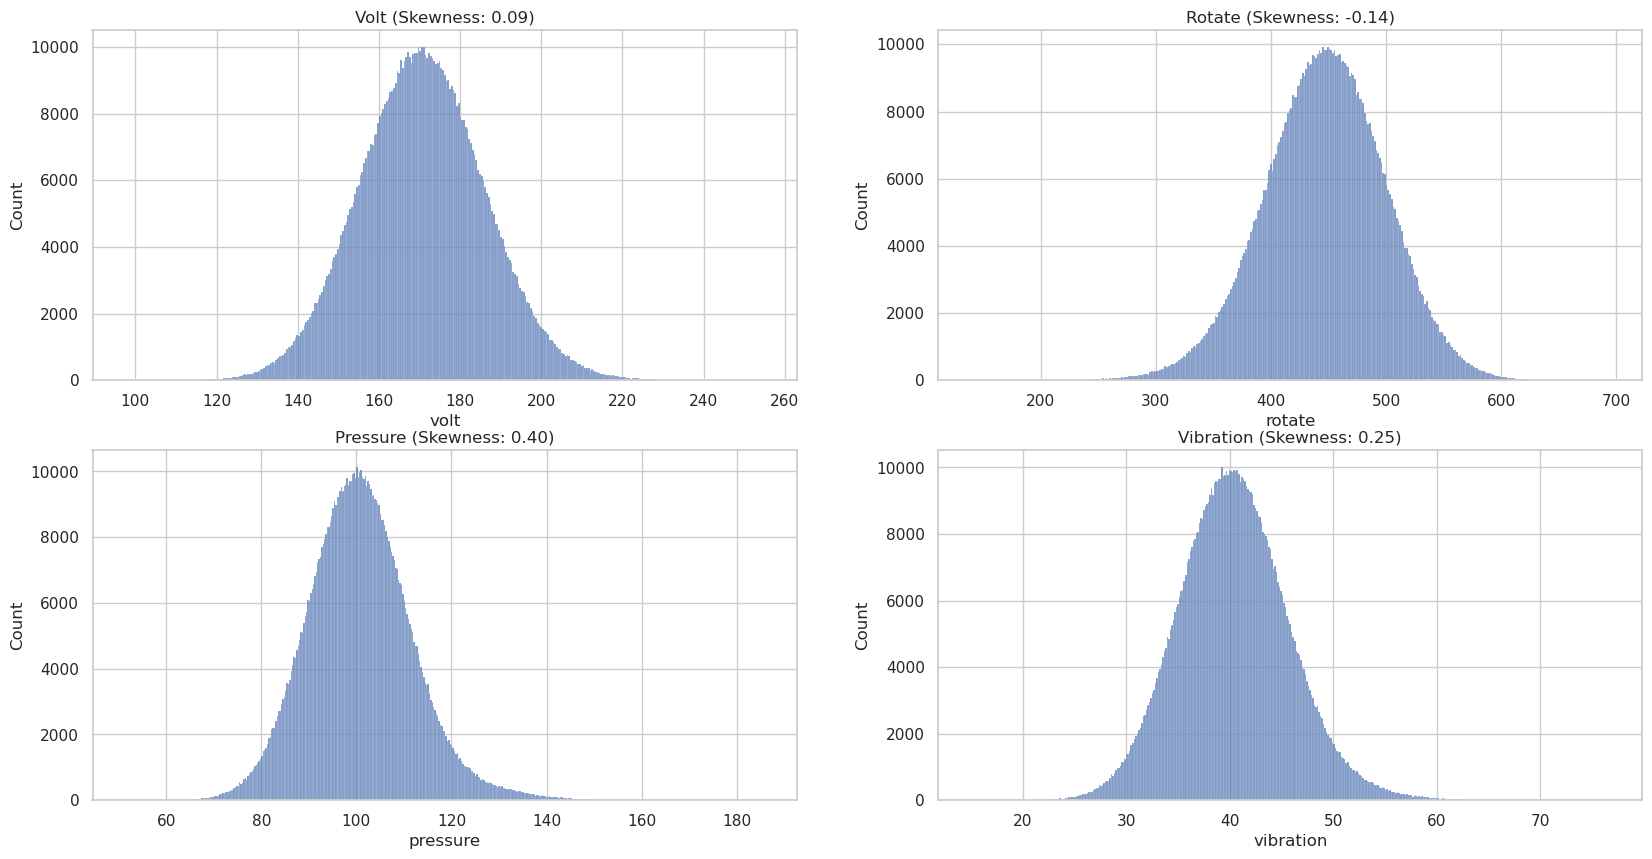

In [272]:
# Gaußsche Normalverteilung der Attribute (volt, rotate, pressure, vibration)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))

# Volt
plt.subplot(2, 2, 1)
sns.histplot(df['volt'])
plt.title(f'Volt (Skewness: {df["volt"].skew():.2f})')

# Rotate
plt.subplot(2, 2, 2)
sns.histplot(df['rotate'])
plt.title(f'Rotate (Skewness: {df["rotate"].skew():.2f})')

# Pressure
plt.subplot(2, 2, 3)
sns.histplot(df['pressure'])
plt.title(f'Pressure (Skewness: {df["pressure"].skew():.2f})')

# Vibration
plt.subplot(2, 2, 4)
sns.histplot(df['vibration'])
plt.title(f'Vibration (Skewness: {df["vibration"].skew():.2f})')

plt.show()


Für das Data Cleaning werden die Verteilungen der vier Attribute volt, rate, pressure und vibration mithilfe von Histogrammen visualisiert. Für jedes Attribut wird zusätzlich die Schiefe berechnet, die im Titel des jeweiligen Plots angezeigt wird. Die Schiefe gibt an, wie asymmetrisch die Verteilung der Daten ist. Ein Wert von 0 deutet auf eine symmetrische Verteilung hin, während positive oder negative Werte auf eine Rechts- bzw. Linksschiefe hinweisen. Diese Visualisierung hilft dabei, die Verteilungen der Attribute besser zu verstehen und zu erkennen, ob sie einer Normalverteilung entsprechen oder signifikante Verzerrungen aufweisen.

In [273]:
# Statistische Ausreißer-Analyse (Mittelwert, Median und Standardabweichung)

# Mittelwert

print("Volt-Mittelwert: ",df['volt'].mean())
print("Rotation-Mittelwert: ",df['rotate'].mean())
print("Pressure-Mittelwert: ",df['pressure'].mean())
print("Vibration-Mittelwert: ",df['vibration'].mean())

# Median

print("Volt-Median: ",df['volt'].median())
print("Rotation-Median: ",df['rotate'].median())
print("Pressure-Median: ",df['pressure'].median())
print("Vibration-Median: ",df['vibration'].median())

# Standardabweichung

print("Volt-Standardabweichung: ",df['volt'].std())
print("Rotation-Standardabweichung: ",df['rotate'].std())
print("Pressure-Standardabweichung: ",df['pressure'].std())
print("Vibration-Standardabweichung: ",df['vibration'].std())



Volt-Mittelwert:  170.78094187513804
Rotation-Mittelwert:  446.5707350330433
Pressure-Mittelwert:  100.86143292362102
Vibration-Mittelwert:  40.386458969965
Volt-Median:  170.609301144424
Rotation-Median:  447.53753810681
Pressure-Median:  100.426820431081
Vibration-Median:  40.2383389800242
Volt-Standardabweichung:  15.511268213588925
Rotation-Standardabweichung:  52.698962770319774
Pressure-Standardabweichung:  11.0521952150491
Vibration-Standardabweichung:  5.371894442197934


In diesem Code wird eine statistische Ausreißer-Analyse für die vier Attribute volt, rotate, pressure und vibration durchgeführt. Es werden der Mittelwert, der Median und die Standardabweichung als zentrale Kennwerte berechnet. Der Mittelwert gibt den Durchschnitt der Werte an und kann durch extreme Ausreißer verzerrt werden. Der Median stellt den zentralen Wert der Verteilung dar und ist weniger empfindlich gegenüber Ausreißern. Die Standardabweichung misst die Streuung der Werte um den Mittelwert und hilft, die Variabilität der Daten zu verstehen. Diese Kennzahlen bieten eine Grundlage, um mögliche Ausreißer zu identifizieren, die sich signifikant vom Mittelwert oder Median unterscheiden oder eine hohe Streuung aufweisen.

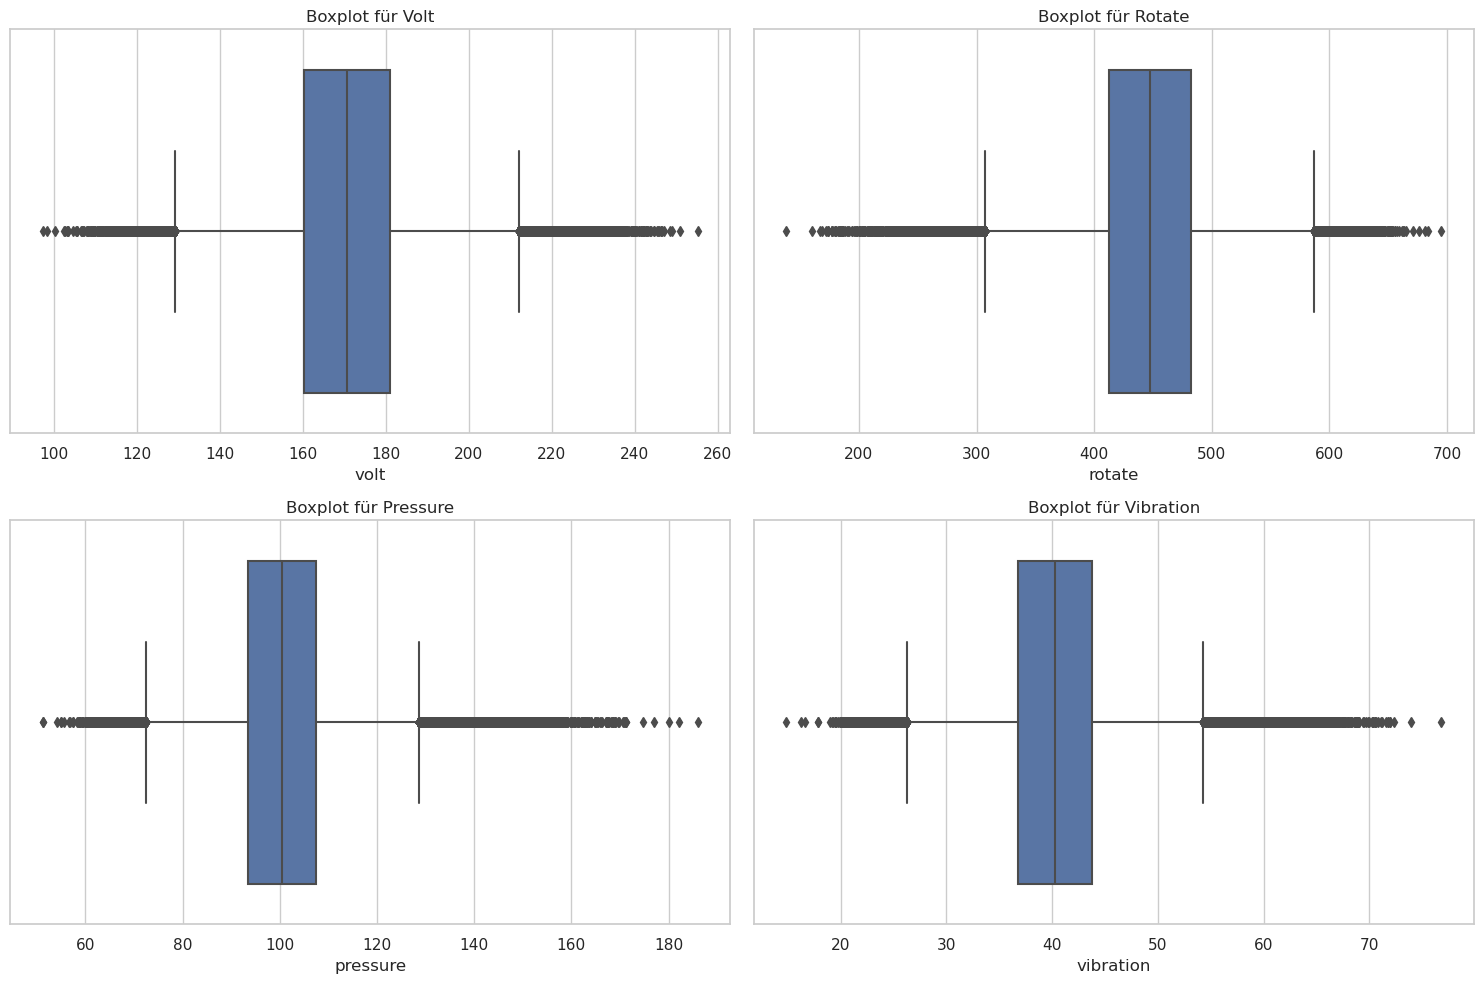

Anzahl der Ausreißer:  7480
Anzahl der Ausreißer (rotate):  8595
Anzahl der Ausreißer (pressure):  15634
Anzahl der Ausreißer (vibration):  11146


In [274]:
# Ausreißer-Analyse mit Boxplot

import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Boxplot für volt
sns.boxplot(x=df['volt'], ax=axs[0, 0])
axs[0, 0].set_title('Boxplot für Volt')

# Boxplot für rotate
sns.boxplot(x=df['rotate'], ax=axs[0, 1])
axs[0, 1].set_title('Boxplot für Rotate')

# Boxplot für pressure
sns.boxplot(x=df['pressure'], ax=axs[1, 0])
axs[1, 0].set_title('Boxplot für Pressure')

# Boxplot für vibration
sns.boxplot(x=df['vibration'], ax=axs[1, 1])
axs[1, 1].set_title('Boxplot für Vibration')

plt.tight_layout()
plt.show()

Q1_volt = df['volt'].quantile(0.25)
Q3_volt = df['volt'].quantile(0.75)

IQR_volt = Q3_volt - Q1_volt

print("Anzahl der Ausreißer: ", ((df['volt'] < (Q1_volt - 1.5 * IQR_volt)) | (df['volt'] > (Q3_volt + 1.5 * IQR_volt))).sum())

Q1_rotate = df['rotate'].quantile(0.25)
Q3_rotate = df['rotate'].quantile(0.75)
IQR_rotate = Q3_rotate - Q1_rotate

print("Anzahl der Ausreißer (rotate): ", ((df['rotate'] < (Q1_rotate - 1.5 * IQR_rotate)) | (df['rotate'] > (Q3_rotate + 1.5 * IQR_rotate))).sum())

Q1_pressure = df['pressure'].quantile(0.25)
Q3_pressure = df['pressure'].quantile(0.75)
IQR_pressure = Q3_pressure - Q1_pressure

print("Anzahl der Ausreißer (pressure): ", ((df['pressure'] < (Q1_pressure - 1.5 * IQR_pressure)) | (df['pressure'] > (Q3_pressure + 1.5 * IQR_pressure))).sum())

Q1_vibration = df['vibration'].quantile(0.25)
Q3_vibration = df['vibration'].quantile(0.75)
IQR_vibration = Q3_vibration - Q1_vibration

print("Anzahl der Ausreißer (vibration): ", ((df['vibration'] < (Q1_vibration - 1.5 * IQR_vibration)) | (df['vibration'] > (Q3_vibration + 1.5 * IQR_vibration))).sum())

Ebenfalls durchgeführt wird eine Ausreißer-Analyse für die Attribute volt, rotate, pressure und vibration. Auch hier werden Boxplots erstellt, um visuell Ausreißer zu identifizieren. Anschließend wird der Interquartilsabstand (IQR) berechnet, und Ausreißer werden als Werte außerhalb des Bereichs Q1 - 1.5 * IQR und Q3 + 1.5 * IQR bestimmt. Die Anzahl der Ausreißer für jedes Attribut wird gezählt und angezeigt. Es ergibt sich eine Anzahl von 7480 Ausreißern in der gesamten Analyse und insgesamt die meisten Ausreißer für das Attribut pressure.

Hier schreiben, dass die Ausreißer zwar identifiziert wurden, aber nicht entfernt werden, da sie für die Analyse wichtig sind. Es sind keine Ausreißer vorhanden, die sehr unrealistisch sind.

### Feature Engineering

In [275]:
df['volt_rotate'] = df['volt'] * df['rotate']

# Pressure und Vibration
df['pressure_vibration'] = df['pressure'] * df['vibration']

df.head()

,datetime,machineID,volt,rotate,pressure,vibration,errorID,failure,comp,model,age,volt_rotate,pressure_vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,0,0,0,3,18,73747.890142,5098.422421
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,0,0,0,3,18,65599.198124,4144.320641
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,0,0,0,3,18,90171.495188,2571.544848
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,0,0,0,3,18,56236.401704,4492.535078
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,0,0,0,3,18,68619.758183,2907.991161


Im Rahmen der Datenvorverarbeitung wird nun Feature Engineering durchgeführt, um neue Merkmake (Features) zu erstellen, die durch Kombination bestehender Attribute entstehen. Volt und Rotate bilden das Attribut volt_rotate, Pressure und Vibration das Attribut pressure_vibration. Diese neuen Features könnten nützlich sein, um komplexe Zusammenhänge zwischen den bestehenden Variablen zu erfassen. 

### Datennormalisierung


In [276]:
# Daten normalisieren auf Werte zwischen 0 und 1

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['volt', 'rotate', 'pressure', 'vibration', 'age', 'volt_rotate', 'pressure_vibration']] = scaler.fit_transform(df[['volt', 'rotate', 'pressure', 'vibration', 'age', 'volt_rotate', 'pressure_vibration']])

# Scaler speichern
joblib.dump(scaler, 'data/scaler.pkl')

df.head()

,datetime,machineID,volt,rotate,pressure,vibration,errorID,failure,comp,model,age,volt_rotate,pressure_vibration
0,2015-01-01 06:00:00,1,0.499928,0.503194,0.459050,0.487945,0,0,0,3,0.9,0.436387,0.466004
1,2015-01-01 07:00:00,1,0.415395,0.474884,0.328274,0.460912,0,0,0,3,0.9,0.366571,0.344464
2,2015-01-01 08:00:00,1,0.466796,0.698752,0.178160,0.311752,0,0,0,3,0.9,0.577100,0.144115
3,2015-01-01 09:00:00,1,0.412756,0.373197,0.430624,0.423896,0,0,0,3,0.9,0.286353,0.388822
4,2015-01-01 10:00:00,1,0.382001,0.533508,0.450207,0.179498,0,0,0,3,0.9,0.392450,0.186973


Mithilfe des MinMaxScalers werden die Werte der Attribute volt, rotate, pressure, vibration und age normalisiert. Der MinMaxScaler skalsiert die Werte jedes Attributs auf einen Bereich zwischen 0 und 1. Die normalisierten Werte werden dann in die ursprüngliche DataFrame übernommen und das Ergebnis wird durch df.head() angezeigt.

### Datentransformation

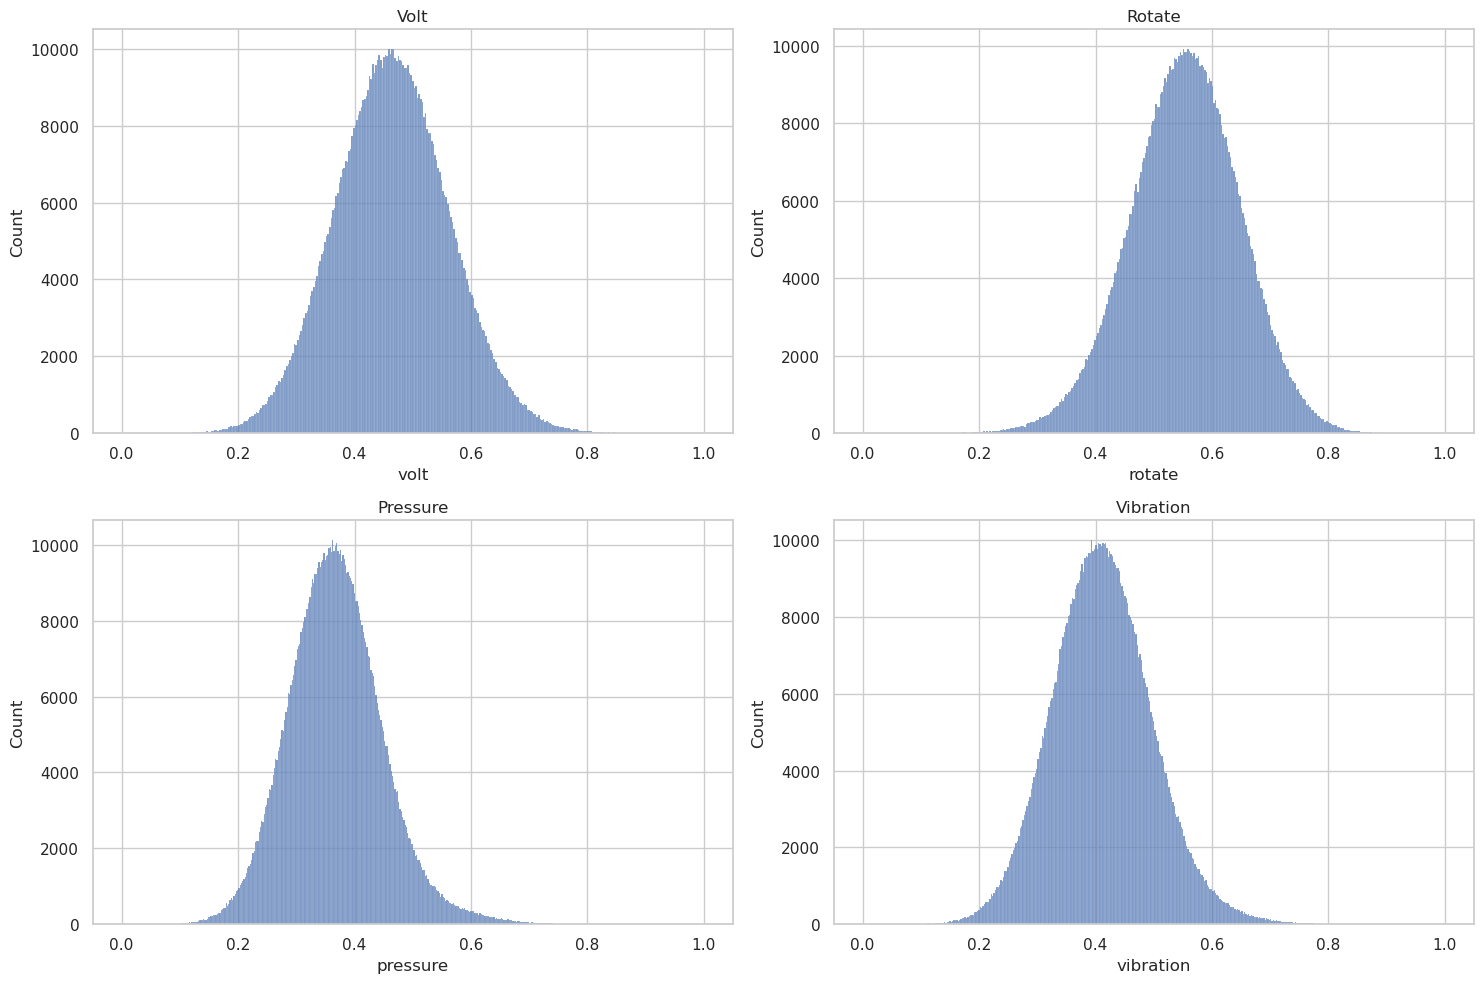

In [277]:
# Gaußsche Normalverteilung der Attribute (volt, rotate, pressure, vibration)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Volt
plt.subplot(2, 2, 1)
sns.histplot(df['volt'])
plt.title('Volt')

# Rotate
plt.subplot(2, 2, 2)
sns.histplot(df['rotate'])
plt.title('Rotate')

# Pressure
plt.subplot(2, 2, 3)
sns.histplot(df['pressure'])
plt.title('Pressure')

# Vibration
plt.subplot(2, 2, 4)
sns.histplot(df['vibration'])
plt.title('Vibration')

plt.tight_layout()
plt.show()

Nach der Datennormalisierung besteht nun auch die Möglichkeit, die Verteilungen der Attribute visuell darzustellen. Dafür werden wieder Histrogramme verwendet, die die normalisierten Daten für die einzelnen Attribute darstellen. Dieser Prozess hilft dabei, die Verteilung der Daten zu überprüfen und mögliche Abweichungen von einer normalen (Gaußschen) Verteilung zu erkennen.

Leicht schief teilweise, aber insgesamt gut normalisiert. (schön umschreiben ;)

### Feature Importance (der ersten 100.000 Messwerte)

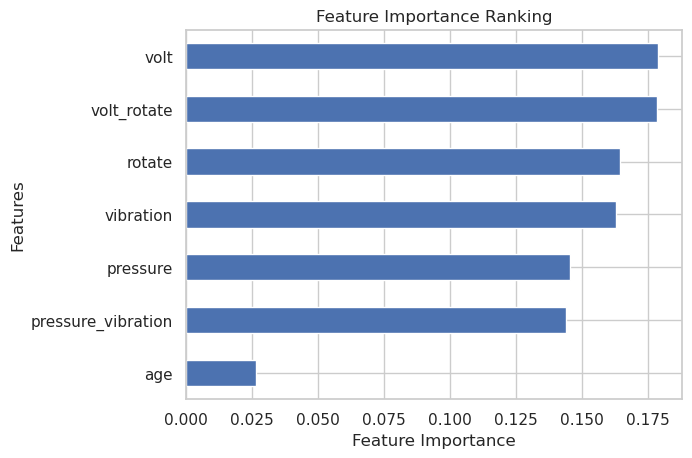

In [278]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

X = df[['volt', 'rotate', 'pressure', 'vibration', 'age', 'volt_rotate', 'pressure_vibration']].head(100000)
y = df['failure'].head(100000)

rf_model = RandomForestClassifier()
rf_model.fit(X, y)

rf_feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
rf_feat_importances.nlargest(10).sort_values().plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Ranking')
plt.show()

Als Abschluss im Rahmen der Datenvorverarbeitung wird ein Random Forest Classifier eingesetzt, um die Bedeutung der verschiedenen Merkmale im Hinblick auf die Vorhersage der Zielgröße failure zu bestimmen. Dazu werden die Eingabedaten aus den Attributen volt, rotate, pressure, vibration, age sowie zwei neu berechneten Merkmalen, volt_rotate und pressure_vibration, zusammengestellt. Die Zielvariable ist failure.

Der Random Forest wird anschließend mit den ersten 100.000 Datenpunkten trainiert. Nach dem Modelltraining werden die Feature Importances extrahiert, welche die relative Bedeutung jedes Merkmals für die Modellvorhersage darstellen. 

### Speicherung

In [279]:
data_raw = df.copy()

Die vorverarbeiteten Daten werden als pickle-Datei abgespeichert und für die weiteren Analysen verwendet.

## Anomalieerkennung

Hier kurz schreiben, dass exemplarische die Maschine 1 als Beispiel genommen wird, da zu unübersichtlich, wenn alle Maschinen betrachtet werden.

### DBSCAN-Algorithmus


Ausreißer-Statistiken:
Anzahl Ausreißer: 99

Ausreißer-Zeitpunkte und Werte:

Zeitpunkt: 2015-01-03 14:00:00
volt: 0.44
rotate: 0.63
pressure: 0.29
vibration: 0.84

Zeitpunkt: 2015-01-04 03:00:00
volt: 0.60
rotate: 0.66
pressure: 0.46
vibration: 0.69

Zeitpunkt: 2015-01-04 11:00:00
volt: 0.75
rotate: 0.57
pressure: 0.33
vibration: 0.59

Zeitpunkt: 2015-01-04 14:00:00
volt: 0.20
rotate: 0.61
pressure: 0.45
vibration: 0.56

Zeitpunkt: 2015-01-12 17:00:00
volt: 0.47
rotate: 0.49
pressure: 0.06
vibration: 0.45

Zeitpunkt: 2015-01-17 07:00:00
volt: 0.89
rotate: 0.64
pressure: 0.33
vibration: 0.48

Zeitpunkt: 2015-01-18 17:00:00
volt: 0.58
rotate: 0.80
pressure: 0.19
vibration: 0.36

Zeitpunkt: 2015-01-26 17:00:00
volt: 0.73
rotate: 0.62
pressure: 0.40
vibration: 0.20

Zeitpunkt: 2015-01-29 21:00:00
volt: 0.18
rotate: 0.67
pressure: 0.25
vibration: 0.56

Zeitpunkt: 2015-02-04 12:00:00
volt: 0.50
rotate: 0.41
pressure: 0.57
vibration: 0.22

Zeitpunkt: 2015-02-20 22:00:00
volt: 0.19
rotate: 0

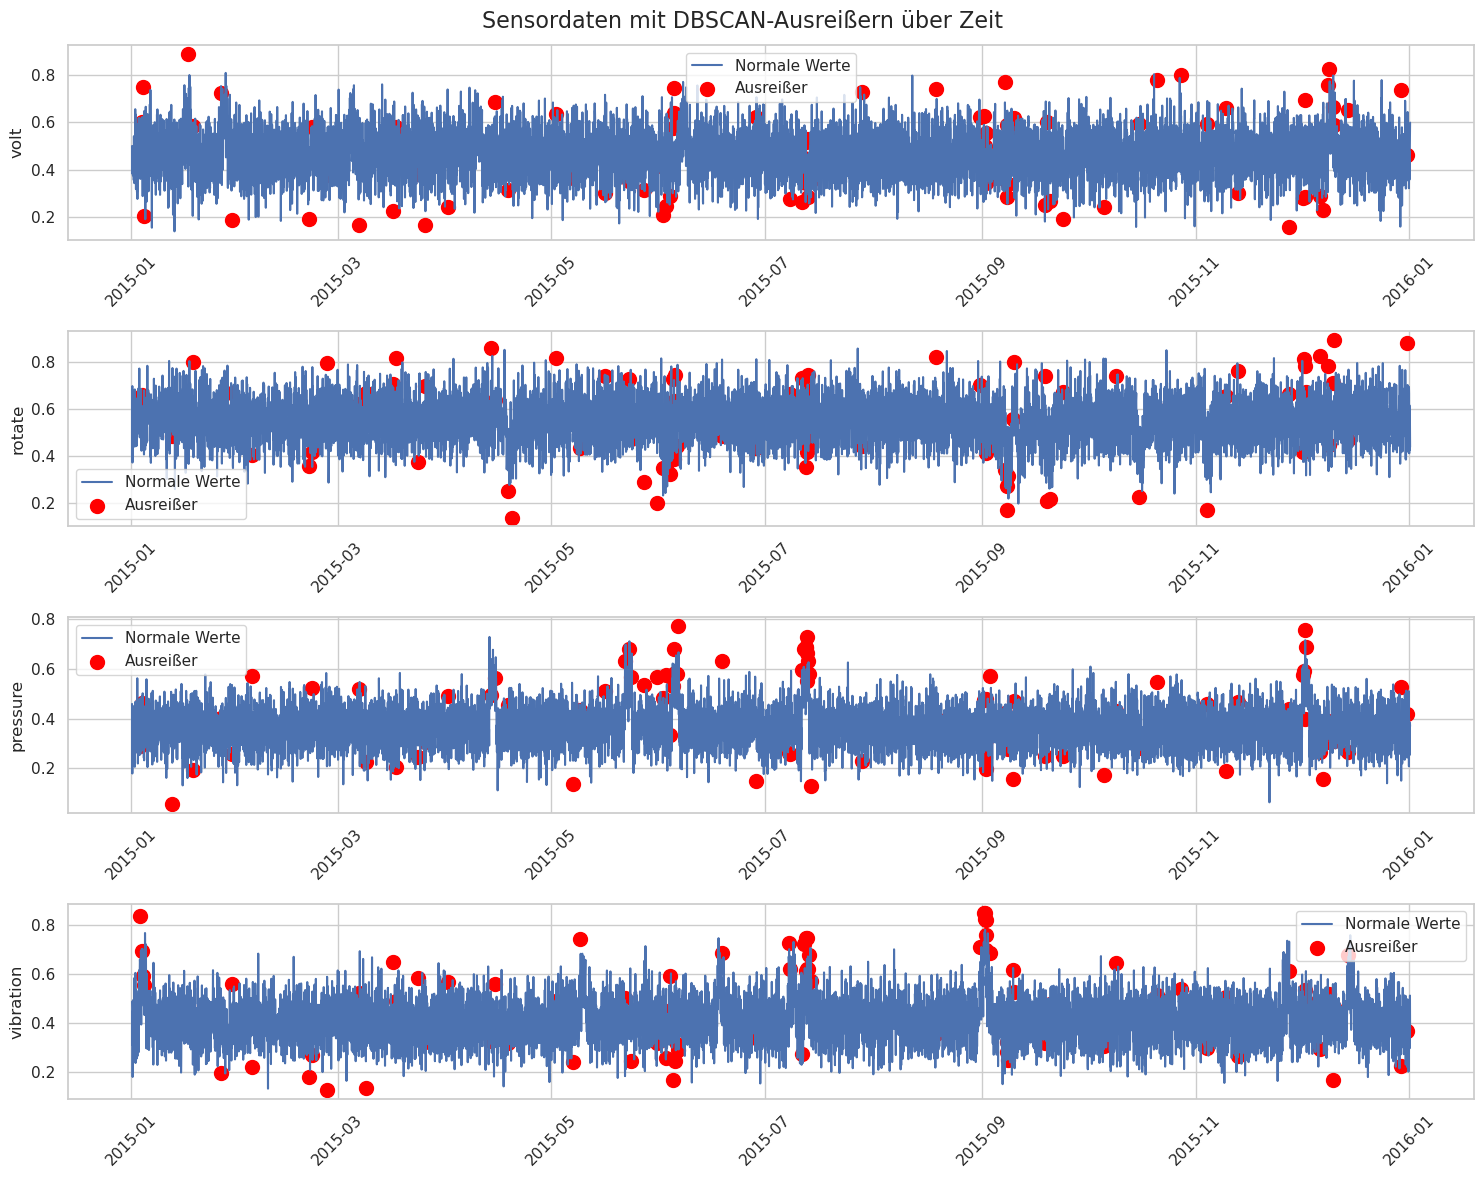

In [280]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
from datetime import datetime
from io import StringIO

df_machine_1 = df[df['machineID'] == 1]
df_machine_1['datetime'] = pd.to_datetime(df_machine_1['datetime'])
features = ['volt', 'rotate', 'pressure', 'vibration']
X = df_machine_1[features]

# DBSCAN für Ausreißererkennung
dbscan = DBSCAN(eps=0.075, min_samples=2)
dbscan_labels = dbscan.fit_predict(X)

# Ausreißer identifizieren (Label -1)
outliers = df_machine_1[dbscan_labels == -1]
normal_points = df_machine_1[dbscan_labels != -1]

# Erstelle mehrere Subplots für jeden Sensor
fig, axes = plt.subplots(4, 1, figsize=(15, 12))
fig.suptitle('Sensordaten mit DBSCAN-Ausreißern über Zeit', fontsize=16)

for idx, feature in enumerate(features):
    # Plot normale Punkte
    axes[idx].plot(normal_points['datetime'], normal_points[feature], 'b-', label='Normale Werte')
    
    # Plot Ausreißer als rote Punkte
    if len(outliers) > 0:
        axes[idx].scatter(outliers['datetime'], outliers[feature], color='red', marker='o', 
                         s=100, label='Ausreißer')
    
    # Formatierung
    axes[idx].set_ylabel(feature)
    axes[idx].grid(True)
    axes[idx].legend()
    
    # Rotiere x-Achsen Labels für bessere Lesbarkeit
    plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=45)

# Enge Layout-Anpassung
plt.tight_layout()

# Statistiken ausgeben
print("\nAusreißer-Statistiken:")
print(f"Anzahl Ausreißer: {len(outliers)}")
if len(outliers) > 0:
    print("\nAusreißer-Zeitpunkte und Werte:")
    for _, row in outliers.iterrows():
        print(f"\nZeitpunkt: {row['datetime']}")
        for feature in features:
            print(f"{feature}: {row[feature]:.2f}")

print("\nStatistische Zusammenfassung der Ausreißer:")
if len(outliers) > 0:
    print(outliers[features].describe())
else:
    print("Keine Ausreißer gefunden")

# Anzahl an Ausreißern
print("\nAnzahl Ausreißer pro Sensor:")
print(outliers[features].count())

### K-Means-Algorithmus

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x79e39f044c10>
Traceback (most recent call last):
  File "/home/EnzoZ/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/EnzoZ/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/EnzoZ/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/EnzoZ/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_m


Ausreißer-Statistiken:
Anzahl Ausreißer: 88

Ausreißer-Zeitpunkte und Werte:

Zeitpunkt: 2015-01-03 14:00:00
volt: 0.44
rotate: 0.63
pressure: 0.29
vibration: 0.84

Zeitpunkt: 2015-01-06 22:00:00
volt: 0.15
rotate: 0.52
pressure: 0.39
vibration: 0.50

Zeitpunkt: 2015-01-12 17:00:00
volt: 0.47
rotate: 0.49
pressure: 0.06
vibration: 0.45

Zeitpunkt: 2015-01-13 09:00:00
volt: 0.14
rotate: 0.61
pressure: 0.40
vibration: 0.36

Zeitpunkt: 2015-01-17 07:00:00
volt: 0.89
rotate: 0.64
pressure: 0.33
vibration: 0.48

Zeitpunkt: 2015-01-17 18:00:00
volt: 0.80
rotate: 0.44
pressure: 0.36
vibration: 0.56

Zeitpunkt: 2015-01-18 17:00:00
volt: 0.58
rotate: 0.80
pressure: 0.19
vibration: 0.36

Zeitpunkt: 2015-01-27 01:00:00
volt: 0.74
rotate: 0.73
pressure: 0.46
vibration: 0.42

Zeitpunkt: 2015-01-29 21:00:00
volt: 0.18
rotate: 0.67
pressure: 0.25
vibration: 0.56

Zeitpunkt: 2015-02-09 02:00:00
volt: 0.35
rotate: 0.58
pressure: 0.17
vibration: 0.13

Zeitpunkt: 2015-02-12 18:00:00
volt: 0.18
rotate: 0

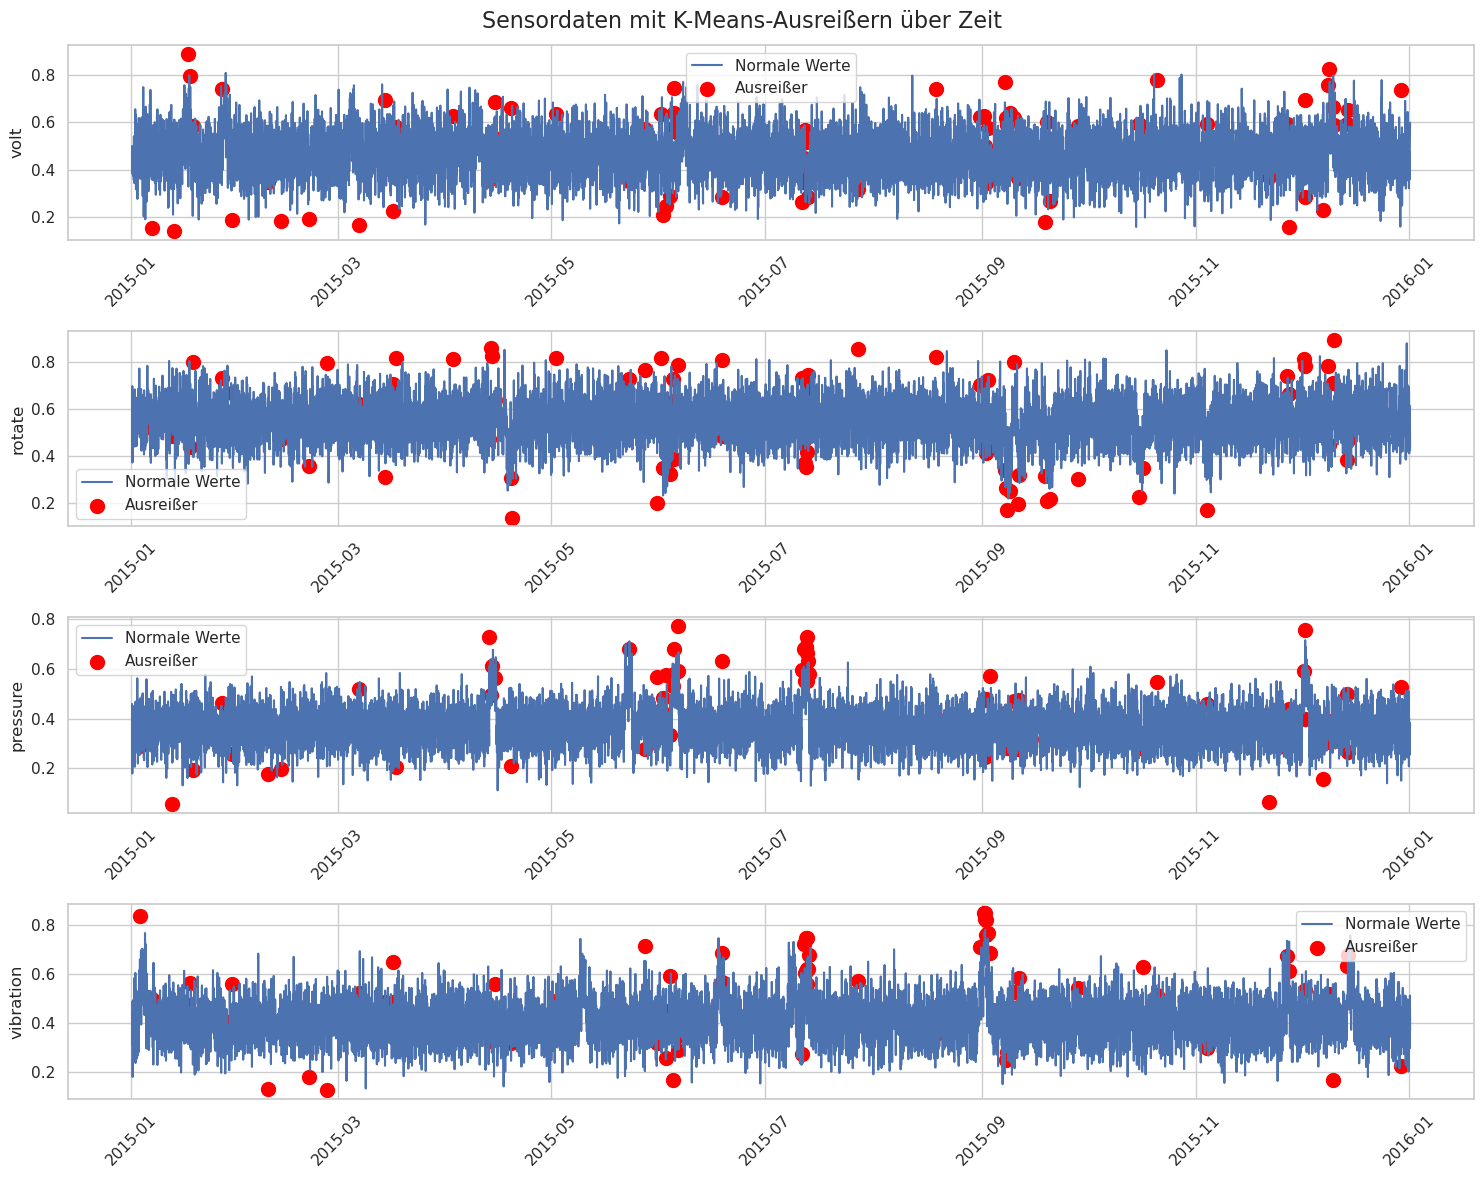

In [281]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X_array = X.values

# K-Means Cluster erstellen
n_clusters = 5 # Anzahl der Cluster, kann angepasst werden
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Cluster-Zentren berechnen
cluster_centers = kmeans.cluster_centers_

# Abstände zum nächstgelegenen Clusterzentrum berechnen
distances = np.min(np.linalg.norm(X_array[:, np.newaxis] - cluster_centers, axis=2), axis=1)

# Ausreißer-Definition: Punkte mit einem Abstand, der eine Schwelle überschreitet
threshold = np.percentile(distances, 99)  # z. B. die obersten 5% der Abstände
outliers = df_machine_1[distances > threshold]
normal_points = df_machine_1[distances <= threshold]

# Erstelle mehrere Subplots für jeden Sensor
fig, axes = plt.subplots(4, 1, figsize=(15, 12))
fig.suptitle('Sensordaten mit K-Means-Ausreißern über Zeit', fontsize=16)

for idx, feature in enumerate(features):
    # Plot normale Punkte
    axes[idx].plot(normal_points['datetime'], normal_points[feature], 'b-', label='Normale Werte')
    
    # Plot Ausreißer als rote Punkte
    if len(outliers) > 0:
        axes[idx].scatter(outliers['datetime'], outliers[feature], color='red', marker='o', 
                          s=100, label='Ausreißer')
    
    # Formatierung
    axes[idx].set_ylabel(feature)
    axes[idx].grid(True)
    axes[idx].legend()
    
    # Rotiere x-Achsen Labels für bessere Lesbarkeit
    plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=45)

# Enge Layout-Anpassung
plt.tight_layout()

# Statistiken ausgeben
print("\nAusreißer-Statistiken:")
print(f"Anzahl Ausreißer: {len(outliers)}")
if len(outliers) > 0:
    print("\nAusreißer-Zeitpunkte und Werte:")
    for _, row in outliers.iterrows():
        print(f"\nZeitpunkt: {row['datetime']}")
        for feature in features:
            print(f"{feature}: {row[feature]:.2f}")

print("\nStatistische Zusammenfassung der Ausreißer:")
if len(outliers) > 0:
    print(outliers[features].describe())
else:
    print("Keine Ausreißer gefunden")

# Anzahl an Ausreißern
print("\nAnzahl Ausreißer pro Sensor:")
print(outliers[features].count())

### Autoencoder

In [282]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt

normal_data = df[(df["errorID"] == 0) & (df["failure"] == 0) & (df["comp"] == 0)]
normal_data = normal_data.drop(["datetime", "machineID", "errorID", "failure", "comp", "model"], axis=1)

Epoch 1/5


21758/21758 [==============================] - 13s 567us/step - loss: 0.0017 - val_loss: 1.6752e-04
Epoch 2/5
21758/21758 [==============================] - 12s 566us/step - loss: 1.6626e-04 - val_loss: 1.7073e-04
Epoch 3/5
21758/21758 [==============================] - 12s 550us/step - loss: 1.6444e-04 - val_loss: 1.6521e-04
Epoch 4/5
21758/21758 [==============================] - 12s 566us/step - loss: 1.6380e-04 - val_loss: 1.6277e-04
Epoch 5/5
5440/5440 [==============================] - 2s 367us/step
Anomalien erkannt: 8704


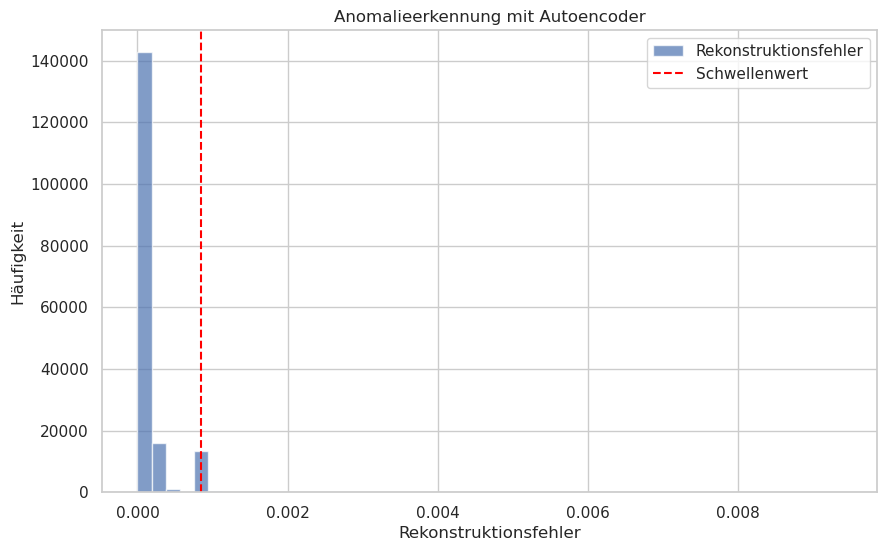

In [283]:
# 5. Trainings- und Testdaten aufteilen
X_train, X_test = train_test_split(normal_data, test_size=0.2, random_state=42)

# 6. Autoencoder-Modell definieren
input_dim = X_train.shape[1]
encoding_dim = 5  # Anzahl der Neuronen im versteckten Layer

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation="relu")(input_layer)
decoded = Dense(input_dim, activation="sigmoid")(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer="adam", loss="mse")

# 7. Modell trainieren
history = autoencoder.fit(X_train, X_train, 
                          epochs=5, 
                          batch_size=32, 
                          validation_data=(X_test, X_test),
                          verbose=1)

# 8. Rekonstruktionsfehler berechnen
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

# 9. Schwellenwert festlegen (z.B. 95. Perzentil des Fehlers)
threshold = np.percentile(mse, 95)

# 10. Anomalien erkennen
anomalies = mse > threshold
print(f"Anomalien erkannt: {np.sum(anomalies)}")

# 11. Ergebnisse visualisieren
plt.figure(figsize=(10, 6))
plt.hist(mse, bins=50, alpha=0.7, label="Rekonstruktionsfehler")
plt.axvline(threshold, color="red", linestyle="--", label="Schwellenwert")
plt.xlabel("Rekonstruktionsfehler")
plt.ylabel("Häufigkeit")
plt.legend()
plt.title("Anomalieerkennung mit Autoencoder")
plt.show()


### SOM mit Quantisierungsfehler

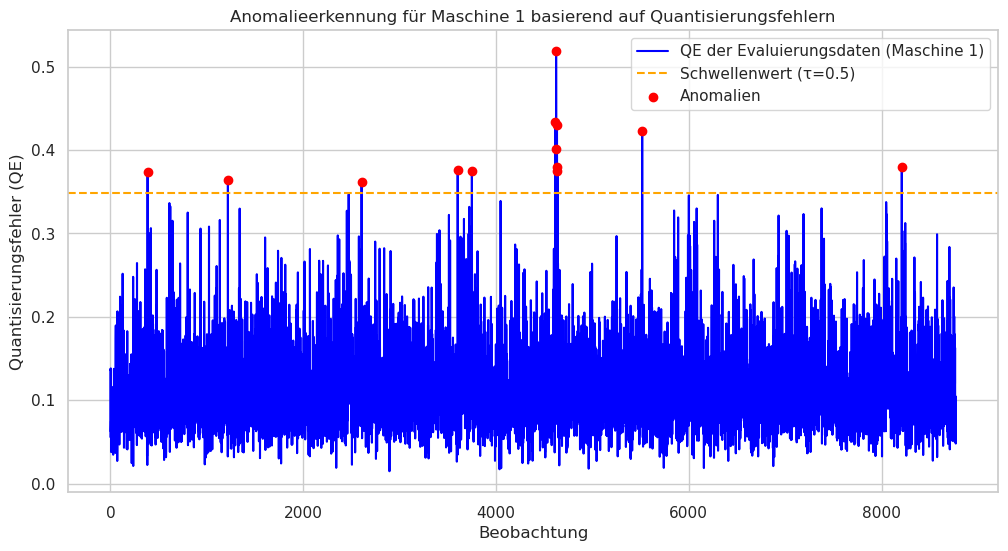

In [284]:
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

data_scaled = df.drop(["datetime", "machineID", "errorID", "failure", "comp", "model"], axis=1)
data_scaled = data_scaled.values

# 2. SOM initialisieren und trainieren
som = MiniSom(x=10, y=10, input_len=data_scaled.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(data_scaled)
som.train_random(data_scaled, num_iteration=100)

# 3. Quantisierungsfehler berechnen
def calculate_quantization_error(som, data):
    errors = []
    for sample in data:
        winner = som.winner(sample)
        weight = som.get_weights()[winner]
        error = np.linalg.norm(sample - weight)
        errors.append(error)
    return np.array(errors)

quantization_errors = calculate_quantization_error(som, data_scaled)

# 4. Schwellenwert berechnen
tau = 0.5  # Justierbarer Parameter
threshold = tau * np.max(quantization_errors)

# 5. Daten filtern: Nur Maschine 1
machine_1_data = df[df["machineID"] == 1]
machine_1_scaled = machine_1_data.drop(["datetime", "machineID", "errorID", "failure", "comp", "model"], axis=1)

# Convert machine_1_scaled to numeric values
machine_1_scaled = machine_1_scaled.apply(pd.to_numeric, errors='coerce').fillna(0).values

machine_1_errors = calculate_quantization_error(som, machine_1_scaled)

# Anomalien für Maschine 1 identifizieren
machine_1_anomalies = machine_1_errors > threshold

# 6. Visualisierung für Maschine 1
time_steps = range(len(machine_1_errors))  # Zeitachse für die Beobachtungen

plt.figure(figsize=(12, 6))
plt.plot(time_steps, machine_1_errors, label="QE der Evaluierungsdaten (Maschine 1)", color="blue")
plt.axhline(y=threshold, color="orange", linestyle="--", label=f"Schwellenwert (τ={tau})")
plt.scatter(
    [time_steps[i] for i in range(len(machine_1_errors)) if machine_1_anomalies[i]],
    [machine_1_errors[i] for i in range(len(machine_1_errors)) if machine_1_anomalies[i]],
    color="red",
    label="Anomalien",
    zorder=3,
)
plt.xlabel("Beobachtung")
plt.ylabel("Quantisierungsfehler (QE)")
plt.title("Anomalieerkennung für Maschine 1 basierend auf Quantisierungsfehlern")
plt.legend()
plt.grid(True)
plt.show()


### Anomalieerkennung mit Überwachtem Lernen

### Identifikation des optimalen Modells

In [ ]:
import anai
from anai.preprocessing import Preprocessor

# Filtere volt, rotate, pressure, vibration und konvertiere 'failure' zu binären Werten
train_data_anai = df[['volt', 'rotate', 'pressure', 'vibration', 'failure']]
train_data_anai['failure'] = train_data_anai['failure'].apply(lambda x: 1 if x > 0 else 0)

ai1 = anai.run(target='failure', df=train_data_anai, predictor=['xgb', 'cat', 'lgbm', 'gbc', 'rfc'], ensemble=False)


Task: Classification 


░█████╗░███╗░░██╗░█████╗░██╗
██╔══██╗████╗░██║██╔══██╗██║
███████║██╔██╗██║███████║██║
██╔══██║██║╚████║██╔══██║██║
██║░░██║██║░╚███║██║░░██║██║
╚═╝░░╚═╝╚═╝░░╚══╝╚═╝░░╚═╝╚═╝
 

Started ANAI [ ✓ ]

Preprocessing Started [*]

Preprocessing Done [ ✓ ]

Training ANAI [*]

[LightGBM] [Info] Number of positive: 10, number of negative: 7007
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 7017, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001425 -> initscore=-6.552080
[LightGBM] [Info] Start training from score -6.552080
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

,Name,Accuracy,Cross Validated Accuracy
0,CatBoost Classifier,100.00000,99.943020
1,Random Forest Classifier,100.00000,99.943020
2,XGBoost Classifier,100.00000,99.914510
3,Gradient Boosting Classifier,99.82906,99.829019
4,LightGBM Classifier,99.94302,99.700733



Completed ANAI Run [ ✓ ]

Saved Best Model at ('anai_info/best/classifier/models/CatBoost_Classifier_1733412049.pkl', 'anai_info/best/classifier/scalers/CatBoost_Classifier_Scaler_1733412049.pkl')  

Time Elapsed :  76.98 seconds 



Hier wird dann rfc als bestes Modell identifiziert.

### Anomalieerkennung mit Random Forest Classifier

In [211]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.model_selection import GridSearchCV

# Prepare the data
df_test['failure'] = df_test['failure'].apply(lambda x: 1 if x > 0 else 0)

features = ['volt', 'rotate', 'pressure', 'vibration', 'volt_rotate', 'pressure_vibration']
X = df_test[features]
y = df_test['failure']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Train a Random Forest model for supervised learning
random_forest = RandomForestClassifier(random_state=42,n_estimators=500, min_samples_split=5, max_features="sqrt", max_depth=33, bootstrap=False, n_jobs=-1)
random_forest.fit(X_train, y_train)

# Predict using Random Forest
rf_predictions = random_forest.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_classification_report = classification_report(y_test, rf_predictions, target_names=["Normal", "Failure"])

Hier kurz Code und Parameter erklären!

In [212]:
print(f"Random Forest Accuracy: {rf_accuracy}")
print(rf_classification_report)

Random Forest Accuracy: 1.0
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1753
     Failure       1.00      1.00      1.00         2

    accuracy                           1.00      1755
   macro avg       1.00      1.00      1.00      1755
weighted avg       1.00      1.00      1.00      1755



Interpretation (Besonders auf die "schlechten" Ergebnisse bei der Failure-Klasse eingehen)

## Predictive Maintenance

### (Feature Enginnering)

In [213]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Filtern der Maschine 1
data = df[df['machineID'] == 1]

data['datetime'] = pd.to_datetime(data['datetime'])

data = data.sort_values(by=['machineID', 'datetime'])
data['comp_replaced'] = (data['comp'] != 0).astype(int)

import numpy as np

data['time_to_next_replacement'] = np.nan

for machine in data['machineID'].unique():
    machine_data = data[data['machineID'] == machine]
    replacement_times = machine_data[machine_data['comp_replaced'] == 1]['datetime']

    if replacement_times.empty:
        continue

    replacement_times = pd.to_datetime(replacement_times)
    next_replacement = replacement_times.iloc[0]

    for idx, row in machine_data.iterrows():
        if row['datetime'] >= next_replacement:
            future_replacements = replacement_times[replacement_times > row['datetime']]
            if not future_replacements.empty:
                next_replacement = future_replacements.iloc[0]
            else:
                break  # Kein weiterer Austausch
        time_delta = (next_replacement - row['datetime']).total_seconds() / 3600  # in Stunden
        data.loc[idx, 'time_to_next_replacement'] = time_delta

features = ['volt', 'rotate', 'pressure', 'vibration', 'age', 'volt_rotate', 'pressure_vibration']



### Darstellung der Verbleibenden Lebensdauer der Maschine 1

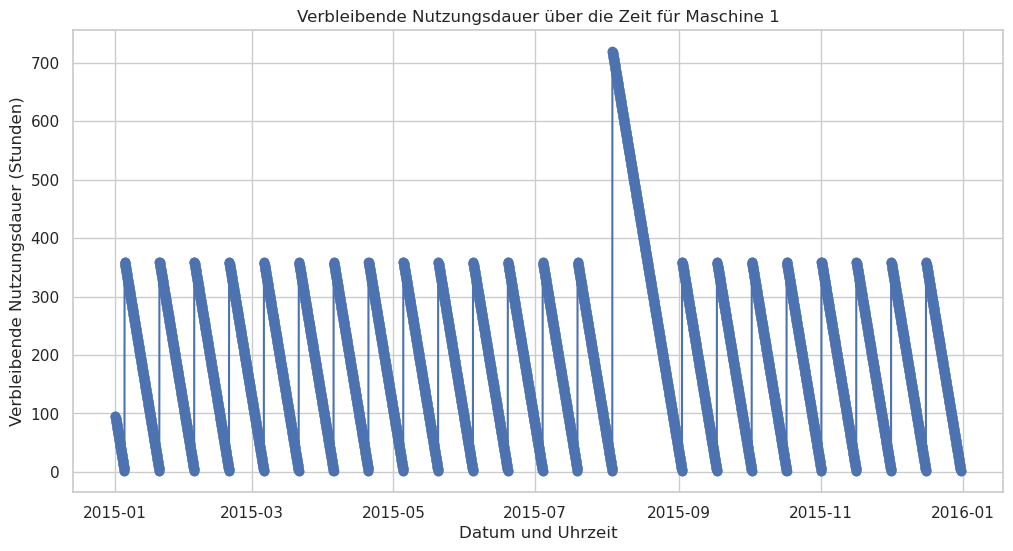

In [214]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12,6))
plt.plot(data['datetime'], data['time_to_next_replacement'], marker='o')
plt.title(f'Verbleibende Nutzungsdauer über die Zeit für Maschine {1}')
plt.xlabel('Datum und Uhrzeit')
plt.ylabel('Verbleibende Nutzungsdauer (Stunden)')
plt.grid(True)
plt.show()


### Random Forest Regressor zur Remaining Useful Life (RUL) Vorhersage

In [215]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

# Load the scaler object
scaler = joblib.load('data/scaler.pkl')

# Set NaN values in the target variable to -1 (außer für die letzten Zeilen)
data['time_to_next_replacement'].fillna(-1, inplace=True)

y = data['time_to_next_replacement']
X_clean = data[features] # Use the same scaler to transform the data

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 104.23143019943018
Root Mean Squared Error (RMSE): 126.56421145353335


### Beispielvorhersage der Remaining Useful Life (RUL)

In [216]:
# Aktuelle Sensordaten erfassen (z.B. aus einer Datenbank oder direkt von den Sensoren)
# Hier ein Beispiel-Datenpunkt
current_data = pd.DataFrame({
    'volt': [170.0],
    'rotate': [420.0],
    'pressure': [100.0],
    'vibration': [40.0],
    'age': [18]
})

current_data['volt_rotate'] = current_data['volt'] * current_data['rotate']
current_data['pressure_vibration'] = current_data['pressure'] * current_data['vibration']

# Die gleichen Vorverarbeitungsschritte anwenden wie beim Training
X_current = scaler.transform(current_data)

# Vorhersage der verbleibenden Nutzungsdauer
rul_prediction = model.predict(X_current)

print(f'Vorhergesagte verbleibende Nutzungsdauer: {rul_prediction[0]:.2f} Stunden')

Vorhergesagte verbleibende Nutzungsdauer: 221.53 Stunden


### Remaining Use Life mit linearer Regression

In [217]:
# Erstelle eine linerae Regression zur Vorhersage der verbleibenden Nutzungsdauer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


# Annahme: 'data' ist Ihr DataFrame mit den Spalten 'volt', 'rotate', 'pressure', 'vibration', 'age' und 'time_to_next_replacement'

X = data[['volt', 'rotate', 'pressure', 'vibration', 'age']]
y = data['time_to_next_replacement']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Ausgabe der Funktion
print(f'Funktion: y = {model.coef_[0]:.2f}*volt + {model.coef_[1]:.2f}*rotate + {model.coef_[2]:.2f}*pressure + {model.coef_[3]:.2f}*vibration + {model.coef_[4]:.2f}*age + {model.intercept_:.2f}')


Funktion: y = -19.74*volt + 25.37*rotate + 62.02*pressure + -59.05*vibration + -109.25*age + 289.36


### Verbleibende Lebensdauer in Bezug auf die Features

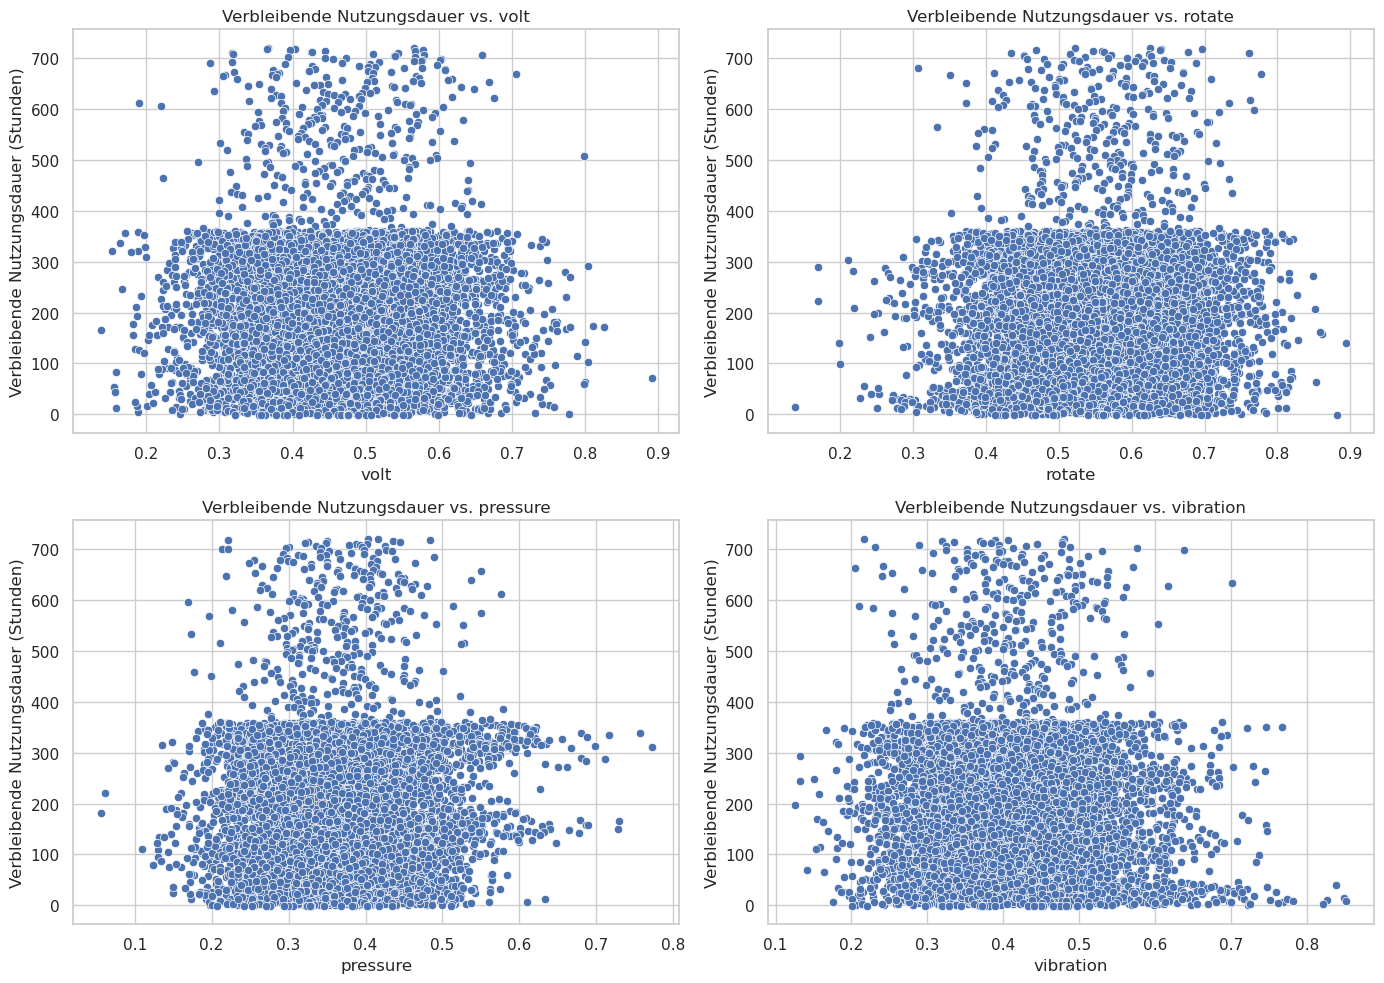

In [218]:
features = ['volt', 'rotate', 'pressure', 'vibration']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.scatterplot(x=feature, y='time_to_next_replacement', data=data, ax=axes[i])
    axes[i].set_title(f'Verbleibende Nutzungsdauer vs. {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Verbleibende Nutzungsdauer (Stunden)')

plt.tight_layout()
plt.show()

### Violinplot der verbleibenden Lebensdauer in Bezug auf die Fehlerklasse

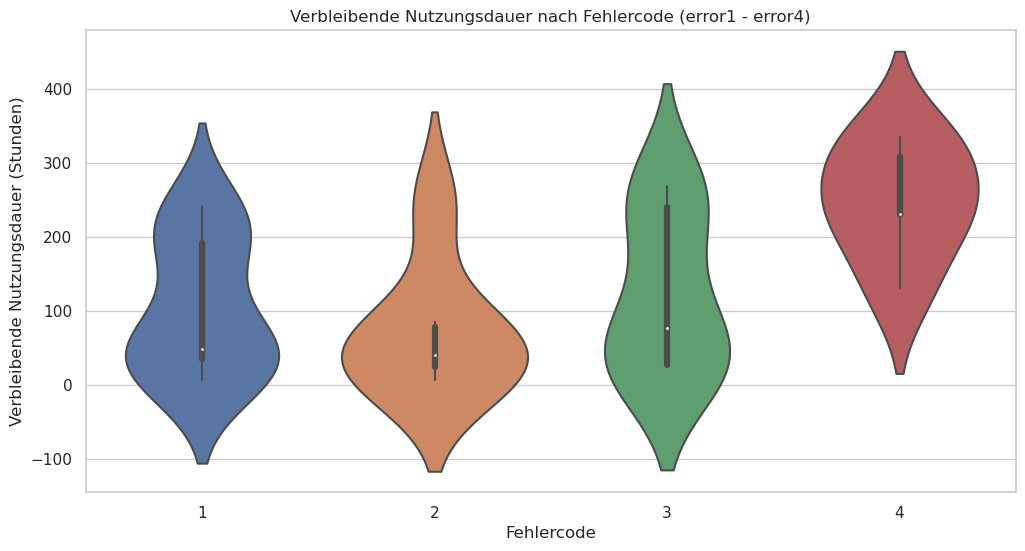

In [219]:
# Vorausgesetzt, die Spalte 'errorID' enthält die Fehlercodes
filtered_data = data[data['errorID'].isin([1, 2, 3, 4])]

plt.figure(figsize=(12,6))
sns.violinplot(x='errorID', y='time_to_next_replacement', data=filtered_data)
plt.title('Verbleibende Nutzungsdauer nach Fehlercode (error1 - error4)')
plt.xlabel('Fehlercode')
plt.ylabel('Verbleibende Nutzungsdauer (Stunden)')
plt.show()


### Schwellenwerte aufstellen um Fehler vorherzusagen (10 % - Schwelle)

In [220]:
columns_to_analyze = ['volt', 'rotate', 'pressure', 'vibration', 'age', 'volt_rotate', 'pressure_vibration']
data_inversive = scaler.inverse_transform(data[columns_to_analyze])

# Umwandlung in einen DataFrame
data_inversive_df = pd.DataFrame(data_inversive, columns=columns_to_analyze)
data_inversive_df['datetime'] = data['datetime'].values  # Füge die Datetime-Spalte hinzu

# Konvertiere 'datetime' in das richtige Datumsformat, falls nötig
data_inversive_df['datetime'] = pd.to_datetime(data_inversive_df['datetime'])

# Tagesaggregation: Nur die relevanten Spalten berücksichtigen
daily_aggregated = data_inversive_df.groupby(data_inversive_df['datetime'].dt.date)[columns_to_analyze].mean()

# Mittelwerte und Schwellenwerte berechnen
mean_values = daily_aggregated.mean()
inverse_upper_thresholds = mean_values + (0.1 * mean_values)
inverse_lower_thresholds = mean_values - (0.1 * mean_values)

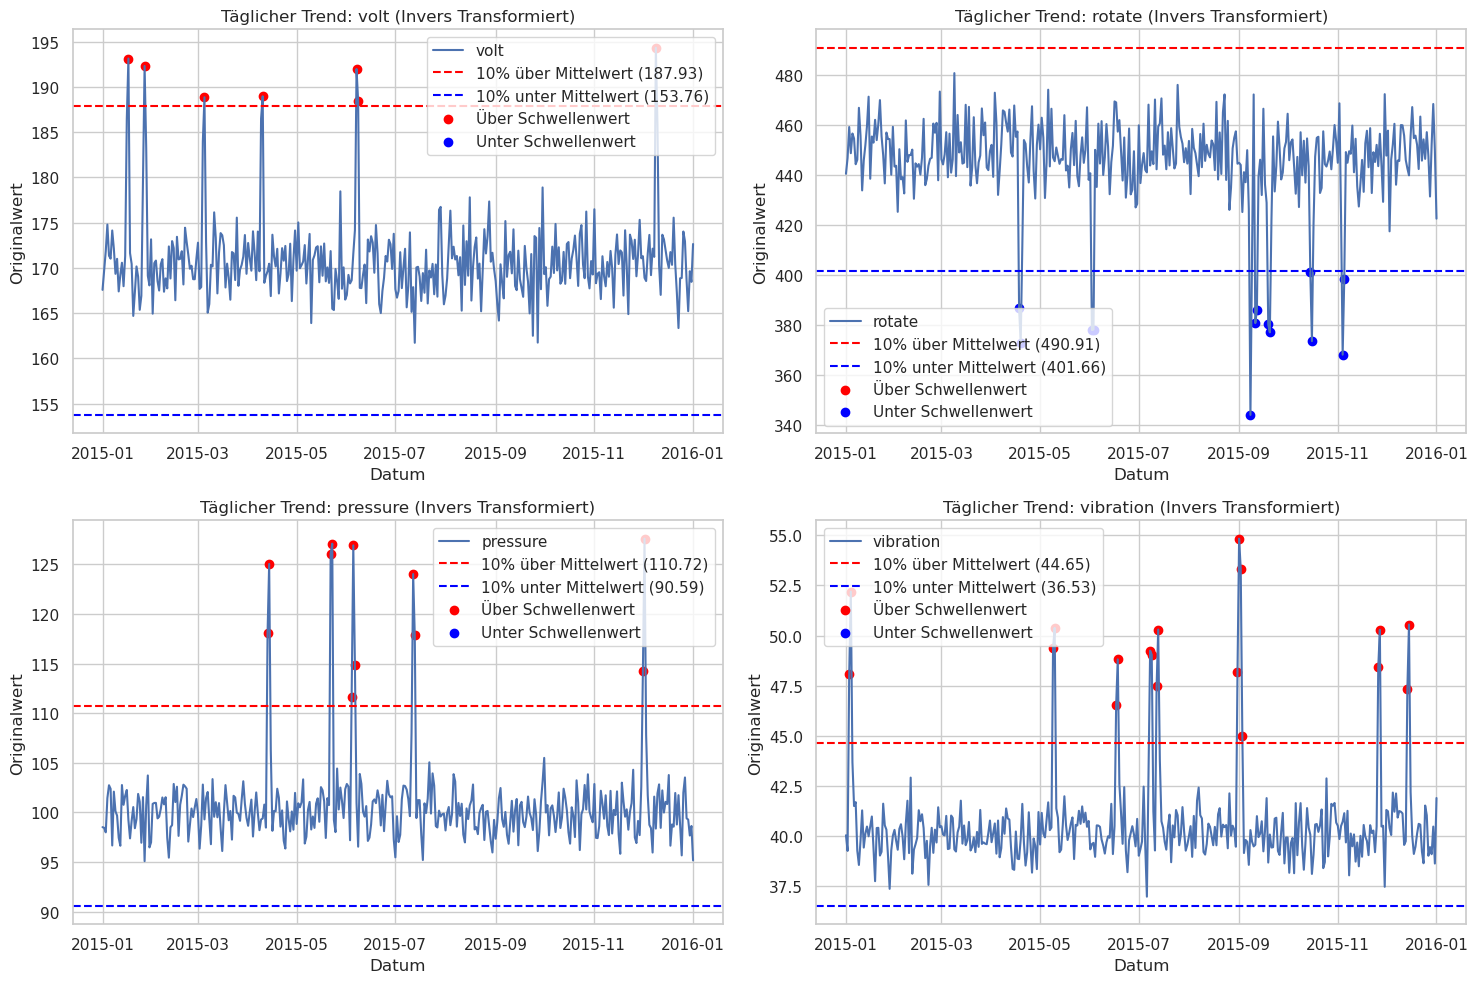

In [221]:
# Plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for ax, (col, lower_threshold, upper_threshold) in zip(
    axes.flat, 
    zip(daily_aggregated.columns, inverse_lower_thresholds, inverse_upper_thresholds)
):
    daily_aggregated.plot(y=col, ax=ax, title=f"Täglicher Trend: {col} (Invers Transformiert)", legend=False)
    ax.axhline(upper_threshold, color='red', linestyle='--', label=f"10% über Mittelwert ({upper_threshold:.2f})")
    ax.axhline(lower_threshold, color='blue', linestyle='--', label=f"10% unter Mittelwert ({lower_threshold:.2f})")
    
    # Highlight datapoints above the threshold
    above_threshold = daily_aggregated[daily_aggregated[col] > upper_threshold]
    below_threshold = daily_aggregated[daily_aggregated[col] < lower_threshold]
    ax.scatter(above_threshold.index, above_threshold[col], color='red', label='Über Schwellenwert')
    ax.scatter(below_threshold.index, below_threshold[col], color='blue', label='Unter Schwellenwert')
    
    ax.legend()

# Achsentitel hinzufügen
for ax in axes.flat:
    ax.set_xlabel("Datum")
    ax.set_ylabel("Originalwert")
    ax.grid(True)

plt.tight_layout()
plt.show()


Hier sieht man dann einen Plot mit den Schwellenwerten und möglichen Ausfällen

In [222]:
comp_mapping = {1: 'comp1', 2: 'comp2', 3: 'comp3', 4: 'comp4'}

# Prüfe auf Datenpunkte, die die invers transformierten Grenzwerte überschreiten
for col, lower_threshold, upper_threshold in zip(
    daily_aggregated.columns, inverse_lower_thresholds, inverse_upper_thresholds
):
    error_data = data_inversive_df[
        (data_inversive_df[col] < lower_threshold) | (data_inversive_df[col] > upper_threshold)
    ]
    if not error_data.empty:
        print(f"Fehlerhafte Datenpunkte für '{col}':")
        display(error_data.head(5))  # Zeige nur die ersten 5 Zeilen
        print("\n")

# Prüfe, ob tatsächlich Fehlercodes vorliegen (wenn 'failure' != 0) und zeige die betroffenen Werte an
error_data_failure = data[
    (data['volt'] < inverse_lower_thresholds['volt']) | 
    (data['volt'] > inverse_upper_thresholds['volt']) |
    (data['rotate'] < inverse_lower_thresholds['rotate']) | 
    (data['rotate'] > inverse_upper_thresholds['rotate']) |
    (data['pressure'] < inverse_lower_thresholds['pressure']) | 
    (data['pressure'] > inverse_upper_thresholds['pressure']) |
    (data['vibration'] < inverse_lower_thresholds['vibration']) | 
    (data['vibration'] > inverse_upper_thresholds['vibration']) |
    (data['age'] < inverse_lower_thresholds['age']) |
    (data['age'] > inverse_upper_thresholds['age']) |
    (data['volt_rotate'] < inverse_lower_thresholds['volt_rotate']) |
    (data['volt_rotate'] > inverse_upper_thresholds['volt_rotate']) |
    (data['pressure_vibration'] < inverse_lower_thresholds['pressure_vibration']) |
    (data['pressure_vibration'] > inverse_upper_thresholds['pressure_vibration'])
    
]
error_data_failure = error_data_failure[error_data_failure['failure'] != 0]

# Rücktransformation für die fehlerhaften Daten
if not error_data_failure.empty:
    inversed_error_data = pd.DataFrame(
        scaler.inverse_transform(error_data_failure[columns_to_analyze]),
        columns=columns_to_analyze,
        index=error_data_failure.index
    )
    inversed_error_data['comp'] = error_data_failure['comp'].map(comp_mapping)
    print("Fehlerhafte Datenpunkte mit Fehlercodes:")
    display(inversed_error_data.head(5))  # Zeige nur die ersten 5 Zeilen
else:
    print("Keine fehlerhaften Datenpunkte mit Fehlercodes gefunden.")

# Evaluation der Qualität: Überprüfung, wie viele echte Fehler mit den Schwellenwerten gefunden wurden
print("Anzahl der tatsächlichen Fehlercodes: ", len(data[data['failure'] != 0]))
print("Anzahl der Fehlercodes, die mit den Schwellenwerten gefunden wurden: ", len(error_data_failure))


Fehlerhafte Datenpunkte für 'volt':


,volt,rotate,pressure,vibration,age,volt_rotate,pressure_vibration,datetime
12,153.353492,490.672921,86.012440,44.108554,18.0,75246.405638,3793.884398,2015-01-01 18:00:00
16,151.335682,444.922656,94.247371,42.119652,18.0,67332.673754,3969.666491,2015-01-01 22:00:00
22,200.872430,403.235951,96.535487,32.516838,18.0,80998.985224,3139.028742,2015-01-02 04:00:00
24,197.363125,446.943947,114.342061,29.527665,18.0,88210.253930,3376.254012,2015-01-02 06:00:00
27,147.300678,420.610792,110.408985,34.203042,18.0,61956.254886,3776.323167,2015-01-02 09:00:00




Fehlerhafte Datenpunkte für 'rotate':


,volt,rotate,pressure,vibration,age,volt_rotate,pressure_vibration,datetime
2,170.989902,527.349825,75.237905,34.178847,18.0,90171.495188,2571.544848,2015-01-01 08:00:00
3,162.462833,346.149335,109.248561,41.122144,18.0,56236.401704,4492.535078,2015-01-01 09:00:00
6,156.556031,499.071623,111.755684,42.753920,18.0,78132.672296,4777.993552,2015-01-01 12:00:00
8,175.324524,398.648781,110.624361,45.482287,18.0,69892.907687,5031.448899,2015-01-01 14:00:00
10,167.060981,382.483543,103.780663,42.675800,18.0,63898.075787,4428.922787,2015-01-01 16:00:00




Fehlerhafte Datenpunkte für 'pressure':


,volt,rotate,pressure,vibration,age,volt_rotate,pressure_vibration,datetime
0,176.217853,418.504078,113.077935,45.087686,18.0,73747.890142,5098.422421,2015-01-01 06:00:00
2,170.989902,527.349825,75.237905,34.178847,18.0,90171.495188,2571.544848,2015-01-01 08:00:00
4,157.610021,435.376873,111.886648,25.990511,18.0,68619.758183,2907.991161,2015-01-01 10:00:00
6,156.556031,499.071623,111.755684,42.753920,18.0,78132.672296,4777.993552,2015-01-01 12:00:00
12,153.353492,490.672921,86.012440,44.108554,18.0,75246.405638,3793.884398,2015-01-01 18:00:00




Fehlerhafte Datenpunkte für 'vibration':


,volt,rotate,pressure,vibration,age,volt_rotate,pressure_vibration,datetime
0,176.217853,418.504078,113.077935,45.087686,18.0,73747.890142,5098.422421,2015-01-01 06:00:00
2,170.989902,527.349825,75.237905,34.178847,18.0,90171.495188,2571.544848,2015-01-01 08:00:00
4,157.610021,435.376873,111.886648,25.990511,18.0,68619.758183,2907.991161,2015-01-01 10:00:00
5,172.504839,430.323362,95.927042,35.655017,18.0,74232.862383,3420.280334,2015-01-01 11:00:00
7,172.522781,409.624717,101.001083,35.482009,18.0,70669.595267,3583.721293,2015-01-01 13:00:00




Fehlerhafte Datenpunkte für 'volt_rotate':


,volt,rotate,pressure,vibration,age,volt_rotate,pressure_vibration,datetime
1,162.879223,402.747490,95.460525,43.413973,18.0,65599.198124,4144.320641,2015-01-01 07:00:00
2,170.989902,527.349825,75.237905,34.178847,18.0,90171.495188,2571.544848,2015-01-01 08:00:00
3,162.462833,346.149335,109.248561,41.122144,18.0,56236.401704,4492.535078,2015-01-01 09:00:00
10,167.060981,382.483543,103.780663,42.675800,18.0,63898.075787,4428.922787,2015-01-01 16:00:00
14,170.335438,402.461187,93.235787,39.739883,18.0,68553.402446,3705.179239,2015-01-01 20:00:00




Fehlerhafte Datenpunkte für 'pressure_vibration':


,volt,rotate,pressure,vibration,age,volt_rotate,pressure_vibration,datetime
0,176.217853,418.504078,113.077935,45.087686,18.0,73747.890142,5098.422421,2015-01-01 06:00:00
2,170.989902,527.349825,75.237905,34.178847,18.0,90171.495188,2571.544848,2015-01-01 08:00:00
4,157.610021,435.376873,111.886648,25.990511,18.0,68619.758183,2907.991161,2015-01-01 10:00:00
5,172.504839,430.323362,95.927042,35.655017,18.0,74232.862383,3420.280334,2015-01-01 11:00:00
6,156.556031,499.071623,111.755684,42.753920,18.0,78132.672296,4777.993552,2015-01-01 12:00:00




Fehlerhafte Datenpunkte mit Fehlercodes:


,volt,rotate,pressure,vibration,age,volt_rotate,pressure_vibration,comp
96,179.303153,499.777962,111.833028,52.383097,18.0,89611.764483,5858.160304,comp4
97,179.303153,499.777962,111.833028,52.383097,18.0,89611.764483,5858.160304,comp1
1539,198.257975,456.862342,89.333995,38.671900,18.0,90576.602655,3454.715313,comp1
2620,180.050801,346.362480,105.661164,39.218055,18.0,62362.841967,4143.825299,comp2
4061,187.673963,493.005160,105.334392,53.963961,18.0,92524.232422,5684.261009,comp1


Anzahl der tatsächlichen Fehlercodes:  11
Anzahl der Fehlercodes, die mit den Schwellenwerten gefunden wurden:  11


Hier wird die "Modellqualität" geprüft, indem geschaut wird, wie viele der tatächlichen Ausfälle vorhergesagt wurden.

## Diagnose

In [226]:
data.head()

,datetime,machineID,volt,rotate,pressure,vibration,errorID,failure,comp,model,age,volt_rotate,pressure_vibration
96,2015-01-05 06:00:00,1,0.519481,0.649215,0.449809,0.605776,0,4,4,3,0.9,0.572304,0.562784
97,2015-01-05 06:00:00,1,0.519481,0.649215,0.449809,0.605776,0,4,1,3,0.9,0.572304,0.562784
1539,2015-03-06 06:00:00,1,0.639607,0.572110,0.282796,0.384321,0,1,1,3,0.9,0.580571,0.256618
2620,2015-04-20 06:00:00,1,0.524220,0.373580,0.403994,0.393142,0,2,2,3,0.9,0.338843,0.344401
4061,2015-06-19 06:00:00,1,0.572531,0.637047,0.401569,0.631309,0,4,1,3,0.9,0.597258,0.540631


In [227]:
import pandas as pd
import joblib

data = data_raw
data = data[data['failure'] != 0]

# Umwandeln (inversiv) von volt, rotate, pressure, vibration, age 
data[['volt', 'rotate', 'pressure', 'vibration', 'age', 'volt_rotate', 'pressure_vibration']] = scaler.inverse_transform(data[['volt', 'rotate', 'pressure', 'vibration', 'age', 'volt_rotate', 'pressure_vibration']])

### Regelbasiert (RBF)

In [232]:
from IPython.display import display

# Berechne die Mittelwerte der relevanten Spalten
mean_values = data[['volt', 'rotate', 'pressure', 'vibration']].mean()

# Setze die Schwellenwerte basierend auf den Mittelwerten
THRESHOLDS = {
    "volt_high": mean_values['volt'] * 1.10,
    "volt_low": mean_values['volt'] * 0.90,
    "rotate_high": mean_values['rotate'] * 1.10,
    "rotate_low": mean_values['rotate'] * 0.90,
    "pressure_high": mean_values['pressure'] * 1.10,
    "pressure_low": mean_values['pressure'] * 0.90,
    "vibration_high": mean_values['vibration'] * 1.10,
    "vibration_low": mean_values['vibration'] * 0.90,
}

def apply_rbs_with_dynamic_thresholds(data, thresholds):
    results = []
    for _, row in data.iterrows():
        rules_triggered = []
        if row['vibration'] > thresholds['vibration_high']:
            rules_triggered.append("High Vibration")
        elif row['vibration'] < thresholds['vibration_low']:
            rules_triggered.append("Low Vibration")
        if row['pressure'] > thresholds['pressure_high']:
            rules_triggered.append("High Pressure")
        elif row['pressure'] < thresholds['pressure_low']:
            rules_triggered.append("Low Pressure")
        if row['rotate'] > thresholds['rotate_high']:
            rules_triggered.append("High Rotation Speed")
        elif row['rotate'] < thresholds['rotate_low']:
            rules_triggered.append("Low Rotation Speed")
        if row['volt'] > thresholds['volt_high']:
            rules_triggered.append("High Voltage")
        elif row['volt'] < thresholds['volt_low']:
            rules_triggered.append("Low Voltage")
        
        # Summarize the diagnosis
        results.append(", ".join(rules_triggered) if rules_triggered else "No Issues")
    
    data['RBS_Diagnosis'] = results
    return data


rbs_results_dynamic = apply_rbs_with_dynamic_thresholds(data, THRESHOLDS)

# Display the first few rows with RBS diagnosis
display(rbs_results_dynamic.head())

,datetime,machineID,volt,rotate,pressure,vibration,errorID,failure,comp,model,age,volt_rotate,pressure_vibration,RBS_Diagnosis
96,2015-01-05 06:00:00,1,179.303153,499.777962,111.833028,52.383097,0,4,4,3,18.0,89611.764483,5858.160304,"High Vibration, High Rotation Speed"
97,2015-01-05 06:00:00,1,179.303153,499.777962,111.833028,52.383097,0,4,1,3,18.0,89611.764483,5858.160304,"High Vibration, High Rotation Speed"
1539,2015-03-06 06:00:00,1,198.257975,456.862342,89.333995,38.671900,0,1,1,3,18.0,90576.602655,3454.715313,"Low Vibration, Low Pressure, High Voltage"
2620,2015-04-20 06:00:00,1,180.050801,346.362480,105.661164,39.218055,0,2,2,3,18.0,62362.841967,4143.825299,Low Rotation Speed
4061,2015-06-19 06:00:00,1,187.673963,493.005160,105.334392,53.963961,0,4,1,3,18.0,92524.232422,5684.261009,"High Vibration, High Rotation Speed"


Schwellwerte auf Basis der vergangenen Anomalieerkennung und Predictive Maintenance festgelegt

### Fallbasiert (CBR)

In [233]:
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
from IPython.display import display

# Implement Case-Based Reasoning (CBR)
# Select relevant features for similarity computation
FEATURES = ['volt', 'rotate', 'pressure', 'vibration']

# Define a function to compute similarity (Euclidean distance here)
def compute_similarity(case, cases):
    distances = euclidean_distances([case], cases)[0]
    return distances

# Apply CBR by finding the most similar historical case
def apply_cbr(data, features):
    case_base = data[features].values
    cbr_diagnoses = []
    for i, current_case in enumerate(case_base):
        # Compare current case to all other cases
        distances = compute_similarity(current_case, np.delete(case_base, i, axis=0))
        # Find the most similar case (smallest distance)
        most_similar_idx = np.argmin(distances)
        # Use the diagnosis of the most similar case (if any)
        cbr_diagnoses.append(data.iloc[most_similar_idx]['RBS_Diagnosis'])
    data['CBR_Diagnosis'] = cbr_diagnoses
    return data

# Apply CBR to the dataset
cbr_results = apply_cbr(rbs_results_dynamic, FEATURES)

# Display the first few rows with CBR diagnosis
display(cbr_results.head())


,datetime,machineID,volt,rotate,pressure,vibration,errorID,failure,comp,model,age,volt_rotate,pressure_vibration,RBS_Diagnosis,CBR_Diagnosis
96,2015-01-05 06:00:00,1,179.303153,499.777962,111.833028,52.383097,0,4,4,3,18.0,89611.764483,5858.160304,"High Vibration, High Rotation Speed","High Vibration, High Rotation Speed"
97,2015-01-05 06:00:00,1,179.303153,499.777962,111.833028,52.383097,0,4,1,3,18.0,89611.764483,5858.160304,"High Vibration, High Rotation Speed","High Vibration, High Rotation Speed"
1539,2015-03-06 06:00:00,1,198.257975,456.862342,89.333995,38.671900,0,1,1,3,18.0,90576.602655,3454.715313,"Low Vibration, Low Pressure, High Voltage","Low Pressure, Low Rotation Speed"
2620,2015-04-20 06:00:00,1,180.050801,346.362480,105.661164,39.218055,0,2,2,3,18.0,62362.841967,4143.825299,Low Rotation Speed,Low Vibration
4061,2015-06-19 06:00:00,1,187.673963,493.005160,105.334392,53.963961,0,4,1,3,18.0,92524.232422,5684.261009,"High Vibration, High Rotation Speed","High Vibration, High Rotation Speed"


Berechnung mit Distanz

### Vergleich der Diagnoseverfahren

In [234]:
from IPython.display import display

# Compare RBS and CBR diagnoses
comparison_results = cbr_results[['RBS_Diagnosis', 'CBR_Diagnosis']]

# Calculate comparison metrics
comparison_metrics = {
    "Total Cases": len(comparison_results),
    "Matching Diagnoses": (comparison_results['RBS_Diagnosis'] == comparison_results['CBR_Diagnosis']).sum(),
    "Differing Diagnoses": (comparison_results['RBS_Diagnosis'] != comparison_results['CBR_Diagnosis']).sum(),
}

# Add a column to highlight differences
comparison_results['Match'] = comparison_results['RBS_Diagnosis'] == comparison_results['CBR_Diagnosis']

# Display comparison summary and results
display(comparison_results)
comparison_metrics


,RBS_Diagnosis,CBR_Diagnosis,Match
96,"High Vibration, High Rotation Speed","High Vibration, High Rotation Speed",True
97,"High Vibration, High Rotation Speed","High Vibration, High Rotation Speed",True
1539,"Low Vibration, Low Pressure, High Voltage","Low Pressure, Low Rotation Speed",False
2620,Low Rotation Speed,Low Vibration,False
4061,"High Vibration, High Rotation Speed","High Vibration, High Rotation Speed",True
...,...,...,...
867650,"Low Vibration, High Voltage",High Voltage,False
868010,Low Voltage,Low Vibration,False
869451,"High Vibration, High Rotation Speed, High Voltage","High Rotation Speed, High Voltage",False
874494,"Low Pressure, High Rotation Speed, High Voltage","Low Vibration, Low Pressure, High Rotation Spe...",False


{'Total Cases': 1122, 'Matching Diagnoses': 825, 'Differing Diagnoses': 297}

### Mögliche Fehlerursachen der Ausfälle darstellen

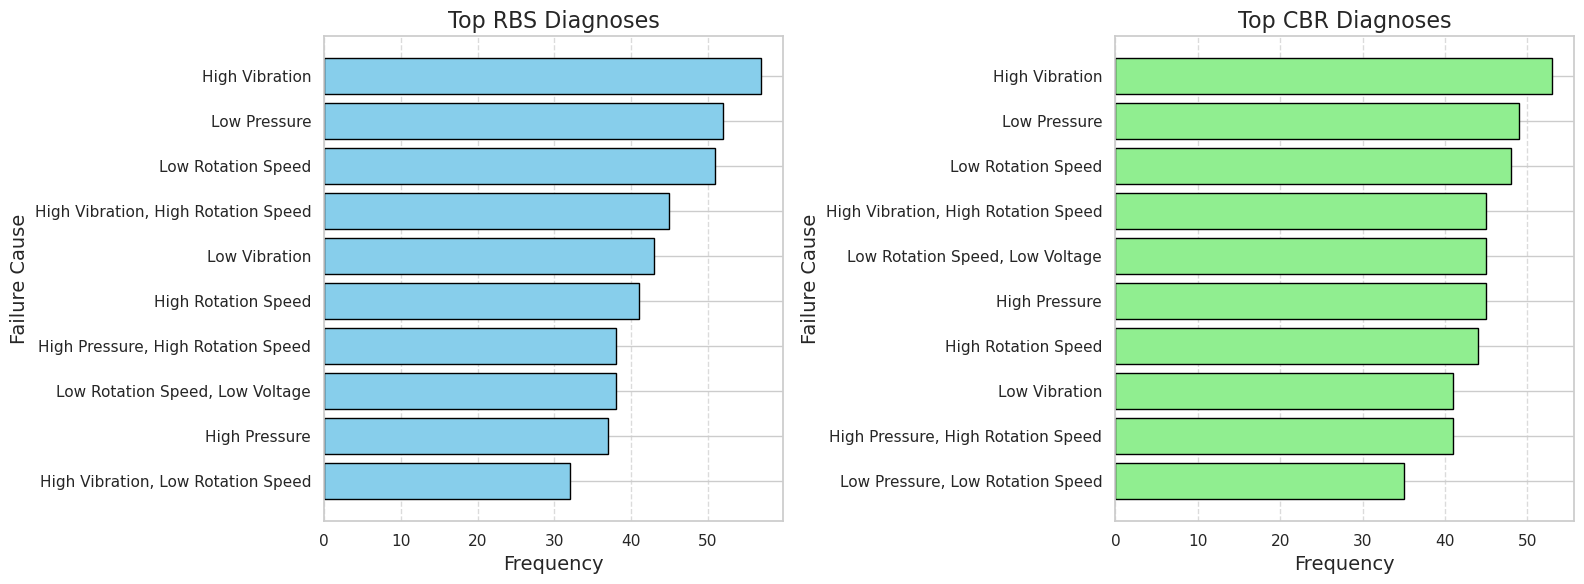

In [235]:
def visualize_two_separate_charts(data, rbs_column='RBS_Diagnosis', cbr_column='CBR_Diagnosis', top_n=10):
    """
    Creates two independent bar charts side-by-side for RBS and CBR diagnoses,
    ensuring no empty fields and unique labeling.

    Parameters:
    - data: DataFrame containing the analysis results.
    - rbs_column: The column name containing RBS diagnosis information.
    - cbr_column: The column name containing CBR diagnosis information.
    - top_n: Number of top causes to display for each method.

    Returns:
    - Two separate bar charts displayed side-by-side.
    """
    # Filter and count the RBS diagnoses
    rbs_counts = data[(data[rbs_column].notna()) & (data[rbs_column] != 'No Issues')][rbs_column].value_counts().head(top_n)

    # Filter and count the CBR diagnoses
    cbr_counts = data[(data[cbr_column].notna()) & (data[cbr_column] != 'No Issues')][cbr_column].value_counts().head(top_n)

    # Create the figure and axes for two separate bar charts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot the RBS diagnoses
    ax1.barh(rbs_counts.index, rbs_counts.values, color='skyblue', edgecolor='black')
    ax1.set_title('Top RBS Diagnoses', fontsize=16)
    ax1.set_xlabel('Frequency', fontsize=14)
    ax1.set_ylabel('Failure Cause', fontsize=14)
    ax1.invert_yaxis()
    ax1.grid(axis='x', linestyle='--', alpha=0.7)

    # Plot the CBR diagnoses
    ax2.barh(cbr_counts.index, cbr_counts.values, color='lightgreen', edgecolor='black')
    ax2.set_title('Top CBR Diagnoses', fontsize=16)
    ax2.set_xlabel('Frequency', fontsize=14)
    ax2.set_ylabel('Failure Cause', fontsize=14)
    ax2.invert_yaxis()
    ax2.grid(axis='x', linestyle='--', alpha=0.7)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# Call the function to create independent visualizations for RBS and CBR
visualize_two_separate_charts(rbs_results_dynamic, rbs_column='RBS_Diagnosis', cbr_column='CBR_Diagnosis')